# Latent Net implementation

>> Notes to the new implementation - debugging

>> - recall that you should scale the velocities according to the paper
>> - get rid of the seeds for the batches
>> - the implementation of the Fourier features is wrong. get back to that later
>> - send data to device only once
>> - make sure that the train function loops over the parameters that are part  of the train set (i.e. the alphas that define the training sims)
>> - the append operation
>> -plot the latent state

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

#torch.set_default_dtype(torch.float32)

In [2]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [3]:
import numpy as np

In [4]:
# Import some utils from gca-rom
import sys
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/Fra-Sala/gnn_time.git
    sys.path.append('gnn_time')
else:
    sys.path.append('./..')
    
#from gca_rom import pde, scaling
from latent_net import dynamics_network, initialization, loader, preprocessing_scale, train

/home/francesco/anaconda3/envs/fenicsproject/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
variable = 'U'
problem_name = 'lid_cavity'
print("\nProblem: ", problem_name)
print("Variable: ", variable)



Problem:  lid_cavity
Variable:  U


In [6]:
# Parameters to be set

#preset = [3, 2, 2, 2, 1, 3, 3, 1]

train_rate = 70 ###### Shrink train dataset
dim_latent = 10
epochs = 400
dt = 1e-1 # For forward euler
scaling_type = 2 # scale only against the features
scaler_number = 3 # type of scaling function. 3 -> standard

argv = [problem_name, variable, scaling_type, scaler_number, train_rate, 1e-3, 1e-3, dim_latent, dt, epochs]
HyperParams = dynamics_network.HyperParams(argv)

# Initialization

In [7]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)

Device used:  cpu


# Load dataset

In [8]:
if 'google.colab' in str(get_ipython()):
    dataset_dir = '/content/gnn_time/dataset/'+problem_name+'_unstructured.mat'
else:
    dataset_dir = '../dataset/'+problem_name+'_unstructured.mat'

# Import the data from the mat file 
dataset = loader.LoadDataset(dataset_dir, variable)

# Delete the initial condition of each case
dataset.U = np.delete(dataset.U, np.s_[::10], 1)

### DEBUG: take only the first two snapshots
dataset.U = np.delete(dataset.U,np.s_[2:],1 )

In [9]:
dataset.U
# I am taking the first (initial condition excluded) snapshot of the very first simulation (first parameter alpha = )

tensor([[0.0380],
        [0.0000],
        [0.0000],
        ...,
        [0.0009],
        [0.0009],
        [0.0041]])

In [10]:
# New approach for the parameters. Just store u(t) for all snapshots and the time t. if necessary, interpolate u(t) linearly

# if 'google.colab' in str(get_ipython()):
#     u_t_latent = np.load('/content/gnn_time/lid_driven_cavity_fenics/u_t_latent.npy')
# else:
#     u_t_latent = np.load('../lid_driven_cavity_fenics/u_t_latent.npy')

# Import the single Fourier mode
if 'google.colab' in str(get_ipython()):
    alpha1_vec = np.load('/content/gnn_time/lid_driven_cavity_fenics/alpha1.npy')
else:
    alpha1_vec = np.load('../lid_driven_cavity_fenics/alpha1.npy')

############ TAKE ONLY THE FIRST PARAMETER (FOURIER COEFF) #############
alpha1_vec = alpha1_vec[0]
time = np.linspace(0.2, 0.4, 2)

# Get rid of the initial condition evaluation (0.0)
# u_t_latent = np.delete(u_t_latent, np.s_[::10], 0)   
# u_t_tensor = torch.from_numpy(u_t_latent)
time_tensor = torch.from_numpy(time)
print("Number of simulations (series of snaps):", len(alpha1_vec))
print("Number of instants of time:", len(time))

alpha1_vec = alpha1_vec.reshape(-1,1)


Number of simulations (series of snaps): 1
Number of instants of time: 1


In [11]:

dataset.U


tensor([[0.0380],
        [0.0000],
        [0.0000],
        ...,
        [0.0009],
        [0.0009],
        [0.0041]])

In [12]:
train_loader, test_loader, scaler_all,\
scaler_test, VAR_all, VAR_test, train_snapshots,\
test_snapshots, position_dataset = preprocessing_scale.process_and_scale_dataset(dataset, HyperParams)

Number of nodes processed:  15681
Number of shapshots processed:  1


In [13]:
data_train_iterator = iter(train_loader)
data_train = next(data_train_iterator).to(device)
data_train.shape

position_dataset

tensor([[-1.0000,  1.0000],
        [-1.0000, -1.0000],
        [ 1.0000, -1.0000],
        ...,
        [ 0.4630, -0.2869],
        [ 0.4734, -0.2765],
        [-0.5859,  0.7095]])

# Define the architecture

In [14]:
# The dynamics net takes u(t) as input and s(t)
dyn_input_size = 1 + HyperParams.dim_latent
dyn_hidden_size = 9
dim = 2 # we are in 2D

#rec_input_size = dim*HyperParams.rff_encoded_mult*HyperParams.batch_pos_size + HyperParams.dim_latent
rec_input_size = dim*HyperParams.batch_pos_size + HyperParams.dim_latent
rec_hidden_size = dyn_hidden_size
rec_output_size = HyperParams.batch_pos_size


dyn_model = dynamics_network.DynNet(dyn_input_size, dyn_hidden_size, HyperParams.dim_latent)
rec_model = dynamics_network.RecNet(rec_input_size, rec_hidden_size, rec_output_size)
dyn_model = dyn_model.to(device)
rec_model = rec_model.to(device)

# Define optimizers for both models
#dyn_optimizer = torch.optim.Adam(list(dyn_model.parameters()) + list(rec_model.parameters()), lr=HyperParams.learning_rate,  weight_decay=HyperParams.weight_decay)
#optimizer = torch.optim.Adam(list(dyn_model.parameters()) + list(rec_model.parameters()), lr=HyperParams.learning_rate,  weight_decay=HyperParams.weight_decay)
torch.set_default_dtype(torch.float32)
optimizer = torch.optim.Adam([
    {'params': dyn_model.parameters()},
    {'params': rec_model.parameters()}
], lr=HyperParams.learning_rate,  weight_decay=HyperParams.weight_decay)
#dyn_optimizer = torch.optim.LBFGS(dyn_model.parameters(), lr=HyperParams.learning_rate)
#rec_optimizer = torch.optim.LBFGS(rec_model.parameters(), lr=HyperParams.learning_rate)
#dyn_scheduler = torch.optim.lr_scheduler.MultiStepLR(dyn_optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

# Train the network

In [15]:
train_history, test_history = train.train_dyn_rec_nets(dyn_model, rec_model, optimizer, scheduler,\
                          device, alpha1_vec ,time_tensor, train_loader, test_loader, position_dataset, train_snapshots, test_snapshots, HyperParams)

  0%|          | 0/400 [00:00<?, ?it/s, Loss(training)=0.825, Loss(test)=0.847]

velocity_pred:  tensor([ 0.1794,  0.1067, -0.3945, -0.0412,  0.1752, -0.0679, -0.3098,  0.2104,
         0.1775,  0.0532], dtype=torch.float64)
velocity_target:  tensor([-0.9787, -0.9703, -0.9961, -0.9746, -0.9754, -0.9656, -0.9659, -0.9674,
        -0.3037, -0.9092], dtype=torch.float64)
velocity_pred:  tensor([ 0.1794,  0.1067, -0.3945, -0.0412,  0.1752, -0.0679, -0.3098,  0.2104,
         0.1775,  0.0532], dtype=torch.float64)
velocity_target:  tensor([-0.9787, -0.9703, -0.9961, -0.9746, -0.9754, -0.9656, -0.9659, -0.9674,
        -0.3037, -0.9092], dtype=torch.float64)
velocity_pred:  tensor([ 0.1326,  0.1130, -0.2247, -0.1019,  0.1855, -0.0942, -0.2436,  0.3973,
         0.0303, -0.0986], dtype=torch.float64)
velocity_target:  tensor([-0.5573, -0.9901, -0.8851, -0.5694, -0.9037, -0.8993, -0.7080, -0.6279,
        -0.8058,  0.6192], dtype=torch.float64)


  0%|          | 2/400 [00:00<00:32, 12.41it/s, Loss(training)=0.835, Loss(test)=0.847]

velocity_pred:  tensor([-0.0064,  0.2412, -0.3854,  0.1282,  0.2122, -0.0768, -0.4031,  0.4195,
         0.2499,  0.1381], dtype=torch.float64)
velocity_target:  tensor([ 1., -1., -1., -1., -1.,  1.,  1., -1., -1.,  1.], dtype=torch.float64)
velocity_pred:  tensor([ 0.0373,  0.2050, -0.4634, -0.0438,  0.0602,  0.0341, -0.2393,  0.2644,
         0.1559,  0.0577], dtype=torch.float64)
velocity_target:  tensor([-0.8078, -0.8844, -0.9598, -0.9906, -0.9739, -0.8964, -0.8938, -0.8931,
        -0.8968, -0.9260], dtype=torch.float64)


  1%|▏         | 5/400 [00:00<00:21, 18.47it/s, Loss(training)=0.814, Loss(test)=0.812]

velocity_pred:  tensor([-0.0780,  0.1434, -0.2862, -0.1004,  0.0287, -0.0222, -0.2960,  0.3888,
         0.1029,  0.1019], dtype=torch.float64)
velocity_target:  tensor([-0.9263, -0.9761, -0.9807,  0.0374, -0.9439, -0.9583, -0.8689, -0.9717,
        -0.9749, -0.9781], dtype=torch.float64)
velocity_pred:  tensor([ 0.0035,  0.1363, -0.4035, -0.1588, -0.0172,  0.0557, -0.2039,  0.2470,
         0.0853,  0.0275], dtype=torch.float64)
velocity_target:  tensor([-0.9820, -0.9840, -0.6779,  0.2664, -0.8794, -0.9689, -0.9235, -0.5010,
        -0.6841, -0.9982], dtype=torch.float64)


  1%|▏         | 5/400 [00:00<00:21, 18.47it/s, Loss(training)=0.794, Loss(test)=0.813]

velocity_pred:  tensor([ 0.0500,  0.1468, -0.4018, -0.0210,  0.1177, -0.0544, -0.3157,  0.2800,
         0.1680,  0.0448], dtype=torch.float64)
velocity_target:  tensor([-0.8875, -0.9515, -0.9900, -0.9625, -0.9604, -0.9561, -0.9615, -0.9422,
        -0.9385, -0.9949], dtype=torch.float64)
velocity_pred:  tensor([ 0.0532,  0.1355, -0.3793,  0.0124,  0.1615, -0.0753, -0.3583,  0.3109,
         0.1838,  0.1173], dtype=torch.float64)
velocity_target:  tensor([-0.9201, -0.9224, -0.9742, -0.9734, -0.9737, -0.6389, -0.5090, -0.9965,
        -0.9028, -0.8972], dtype=torch.float64)


  2%|▏         | 9/400 [00:00<00:16, 24.20it/s, Loss(training)=0.792, Loss(test)=0.775]

velocity_pred:  tensor([-0.0273,  0.1779, -0.3828, -0.1376, -0.0078,  0.0227, -0.2407,  0.2955,
         0.0960,  0.0028], dtype=torch.float64)
velocity_target:  tensor([-0.8599, -0.9603, -0.8629, -0.9805, -0.9786, -0.9349, -0.9380, -0.8250,
        -0.8300, -0.8245], dtype=torch.float64)
velocity_pred:  tensor([ 0.2639,  0.0319, -0.3082, -0.3234,  0.0849,  0.0415, -0.1971,  0.1368,
         0.0373, -0.2318], dtype=torch.float64)
velocity_target:  tensor([-0.9200, -0.9723, -0.8381, -0.9953, -0.9455, -1.0000, -0.8791, -0.8736,
        -0.9937, -0.9579], dtype=torch.float64)
velocity_pred:  tensor([ 0.1155,  0.0694, -0.3183, -0.1192,  0.1332, -0.0593, -0.2707,  0.2867,
         0.0644, -0.0004], dtype=torch.float64)
velocity_target:  tensor([-0.9632, -0.9224, -0.9280, -0.8891, -0.9763, -0.8866, -0.8876, -0.9159,
        -0.9169, -0.9172], dtype=torch.float64)


  3%|▎         | 13/400 [00:00<00:13, 28.13it/s, Loss(training)=0.797, Loss(test)=0.78]

velocity_pred:  tensor([-0.0607,  0.0671, -0.3375, -0.2488, -0.0715,  0.0371, -0.2497,  0.2333,
         0.0544, -0.0285], dtype=torch.float64)
velocity_target:  tensor([-0.9835, -0.9832, -0.0493, -0.9711, -0.8794, -0.8697, -0.9815, -0.9799,
        -0.9937, -0.9983], dtype=torch.float64)
velocity_pred:  tensor([ 0.0400,  0.1451, -0.3449, -0.1782,  0.0146, -0.0635, -0.3045,  0.2262,
         0.1268, -0.1455], dtype=torch.float64)
velocity_target:  tensor([-0.2728, -0.4850, -0.9938, -0.7168, -0.8826, -0.9668, -0.9631, -0.9638,
        -0.9479, -0.9338], dtype=torch.float64)


  3%|▎         | 13/400 [00:00<00:13, 28.13it/s, Loss(training)=0.777, Loss(test)=0.769]

velocity_pred:  tensor([ 0.0341,  0.0835, -0.3274, -0.2538, -0.0166,  0.0084, -0.2545,  0.2189,
         0.0586, -0.0930], dtype=torch.float64)
velocity_target:  tensor([-0.9837, -0.9819, -0.4468, -0.9193, -0.8836, -0.9342, -0.9219, -0.9678,
        -0.6710, -0.9749], dtype=torch.float64)
velocity_pred:  tensor([-0.0860,  0.1197, -0.3623, -0.1017, -0.0104, -0.0904, -0.2518,  0.3185,
         0.0374, -0.0636], dtype=torch.float64)
velocity_target:  tensor([-0.9117, -0.8659, -0.8537, -0.9610, -0.8930, -0.6863, -0.8616, -0.9077,
        -0.9300, -0.8716], dtype=torch.float64)


  4%|▍         | 16/400 [00:00<00:13, 27.44it/s, Loss(training)=0.78, Loss(test)=0.781] 

velocity_pred:  tensor([ 0.2397, -0.0090, -0.3069, -0.3441,  0.0512,  0.0071, -0.1292,  0.1468,
        -0.0669, -0.2427], dtype=torch.float64)
velocity_target:  tensor([-0.9363, -0.9394, -0.6886, -0.9810, -0.9336, -0.9983, -0.9359, -0.3825,
        -0.9402, -0.9631], dtype=torch.float64)
velocity_pred:  tensor([ 0.0724,  0.0567, -0.3452, -0.1538,  0.0685, -0.0877, -0.2184,  0.2600,
        -0.0066, -0.1396], dtype=torch.float64)
velocity_target:  tensor([-0.9473, -0.9190, -0.7669, -0.9867, -0.6722, -0.3568, -0.9708, -0.8399,
        -0.9744, -0.7865], dtype=torch.float64)


  4%|▍         | 16/400 [00:00<00:13, 27.44it/s, Loss(training)=0.783, Loss(test)=0.767]

velocity_pred:  tensor([-0.0111,  0.0997, -0.4418, -0.2183, -0.0869, -0.0136, -0.2137,  0.1443,
         0.0557, -0.1397], dtype=torch.float64)
velocity_target:  tensor([-1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -0.8709, -0.8287,
        -0.8140, -0.8414], dtype=torch.float64)


  5%|▍         | 19/400 [00:00<00:15, 24.01it/s, Loss(training)=0.773, Loss(test)=0.772]

velocity_pred:  tensor([ 0.0712,  0.0213, -0.3716, -0.1349,  0.0668, -0.1384, -0.2815,  0.1878,
         0.0448, -0.0952], dtype=torch.float64)
velocity_target:  tensor([-0.8258,  0.1165, -0.9190, -0.7772, -0.8577, -0.9626, -0.9791, -0.9375,
        -0.8557, -0.9675], dtype=torch.float64)


  5%|▍         | 19/400 [00:00<00:15, 24.01it/s, Loss(training)=0.749, Loss(test)=0.742]

velocity_pred:  tensor([ 0.0580,  0.1431, -0.3631, -0.1669,  0.0344, -0.0378, -0.2660,  0.2560,
         0.0818, -0.1100], dtype=torch.float64)
velocity_target:  tensor([-0.9488, -0.9663, -0.9337, -0.8797, -0.7750, -0.7618, -0.8839, -0.9225,
        -0.8861, -0.9472], dtype=torch.float64)
velocity_pred:  tensor([-0.0534,  0.1462, -0.4074, -0.1722, -0.0535, -0.0053, -0.2403,  0.2579,
         0.0532, -0.0388], dtype=torch.float64)
velocity_target:  tensor([-0.8599, -0.9603, -0.8629, -0.9805, -0.9786, -0.9349, -0.9380, -0.8250,
        -0.8300, -0.8245], dtype=torch.float64)


  6%|▌         | 22/400 [00:00<00:16, 23.60it/s, Loss(training)=0.762, Loss(test)=0.742]

velocity_pred:  tensor([ 0.1649,  0.0662, -0.3912, -0.1897,  0.0821, -0.0463, -0.2784,  0.1462,
         0.0956, -0.1370], dtype=torch.float64)
velocity_target:  tensor([-0.8556, -0.9451, -0.9588, -0.9566, -0.8568, -0.9721,  0.3359, -0.9248,
        -0.9284, -0.9526], dtype=torch.float64)
velocity_pred:  tensor([ 0.1013,  0.1729, -0.4208, -0.1072,  0.0898, -0.0183, -0.3209,  0.2304,
         0.1606, -0.0240], dtype=torch.float64)
velocity_target:  tensor([-0.9454, -0.9460, -0.9688, -0.9994, -0.9984, -0.9127, -0.8517, -0.8786,
        -0.8601, -0.8416], dtype=torch.float64)


  6%|▋         | 26/400 [00:01<00:13, 26.77it/s, Loss(training)=0.734, Loss(test)=0.745]

velocity_pred:  tensor([ 0.1089,  0.0292, -0.3650, -0.2124,  0.0359, -0.1050, -0.2038,  0.1817,
        -0.0304, -0.2317], dtype=torch.float64)
velocity_target:  tensor([ 0.0188, -0.3829, -0.1150, -0.9394, -0.9413, -0.9224, -0.8619, -0.9342,
        -0.9516, -0.6643], dtype=torch.float64)
velocity_pred:  tensor([ 0.1366,  0.0746, -0.3387, -0.1740,  0.1144, -0.0498, -0.3085,  0.2316,
         0.0798, -0.0882], dtype=torch.float64)
velocity_target:  tensor([-0.9418, -0.9491, -0.9604, -0.9872, -0.9883, -0.9657, -0.9652, -0.6934,
        -0.8831, -0.9285], dtype=torch.float64)
velocity_pred:  tensor([-0.0105,  0.0773, -0.3507, -0.2440, -0.0460, -0.0144, -0.2188,  0.2473,
        -0.0121, -0.1167], dtype=torch.float64)
velocity_target:  tensor([-0.9715, -0.9724, -0.8419, -0.8599, -0.8950, -0.8509, -0.9607, -0.8487,
        -0.9558, -0.9622], dtype=torch.float64)


  6%|▋         | 26/400 [00:01<00:13, 26.77it/s, Loss(training)=0.728, Loss(test)=0.732]

velocity_pred:  tensor([ 0.0626,  0.0243, -0.2926, -0.1533,  0.0832, -0.1571, -0.2956,  0.2723,
         0.0048, -0.0566], dtype=torch.float64)
velocity_target:  tensor([-0.9751, -0.9127, -0.9131, -0.8073, -0.9710, -0.6076, -0.7521, -0.9934,
        -0.9855, -0.8742], dtype=torch.float64)
velocity_pred:  tensor([ 0.1325, -0.0578, -0.2920, -0.1340,  0.1363, -0.2588, -0.2523,  0.2329,
        -0.0743, -0.1796], dtype=torch.float64)
velocity_target:  tensor([-0.8846, -0.6765, -0.8571, -0.9601, -0.9162, -0.9585, -1.0000, -0.9706,
        -0.9283, -0.8252], dtype=torch.float64)


  8%|▊         | 30/400 [00:01<00:12, 28.83it/s, Loss(training)=0.71, Loss(test)=0.729] 

velocity_pred:  tensor([ 0.1198, -0.0448, -0.3255, -0.2155,  0.0655, -0.1499, -0.2091,  0.1914,
        -0.0767, -0.2219], dtype=torch.float64)
velocity_target:  tensor([-0.8661, -0.8407, -0.8431, -0.8181, -0.9440, -0.8264, -0.8265, -0.8182,
        -0.9708, -0.9698], dtype=torch.float64)
velocity_pred:  tensor([ 0.0386,  0.0309, -0.3863, -0.3008, -0.0883, -0.0272, -0.1756,  0.1445,
        -0.0437, -0.1211], dtype=torch.float64)
velocity_target:  tensor([-0.9709, -0.9057, -0.8941, -0.9400, -0.9688, -0.9696, -0.9672, -0.8553,
        -0.9513, -0.9702], dtype=torch.float64)


  8%|▊         | 30/400 [00:01<00:12, 28.83it/s, Loss(training)=0.721, Loss(test)=0.715]

velocity_pred:  tensor([ 0.0128,  0.0829, -0.4318, -0.2315, -0.0567, -0.0251, -0.2511,  0.1487,
         0.0468, -0.1577], dtype=torch.float64)
velocity_target:  tensor([-0.8505, -0.8507, -0.9005, -0.9713, -0.9297, -0.8985, -0.9025, -0.9526,
        -0.9666, -0.8823], dtype=torch.float64)
velocity_pred:  tensor([-0.0171,  0.0532, -0.3620, -0.2445, -0.0536, -0.0629, -0.2136,  0.2289,
        -0.0452, -0.1772], dtype=torch.float64)
velocity_target:  tensor([-0.1925, -0.8675, -0.9021, -0.9549, -0.9436, -0.8828, -0.9885, -0.8325,
        -0.9994, -0.9828], dtype=torch.float64)
velocity_pred:  tensor([-0.0340,  0.0769, -0.3170, -0.2053, -0.0181, -0.0839, -0.2975,  0.2744,
         0.0305, -0.1279], dtype=torch.float64)
velocity_target:  tensor([-0.8482, -0.9697, -0.9950, -0.7833, -0.9215, -0.8869, -0.9155, -0.9651,
        -0.9897, -0.9341], dtype=torch.float64)


  8%|▊         | 33/400 [00:01<00:12, 28.92it/s, Loss(training)=0.725, Loss(test)=0.717]

velocity_pred:  tensor([ 0.1078,  0.0043, -0.4279, -0.3060, -0.0492, -0.0086, -0.1629,  0.0927,
        -0.0460, -0.1992], dtype=torch.float64)
velocity_target:  tensor([-0.8767, -0.9292, -0.8541, -0.9770, -0.7577, -0.9539, -0.8824, -0.9166,
        -0.9642, -0.9813], dtype=torch.float64)


  8%|▊         | 33/400 [00:01<00:12, 28.92it/s, Loss(training)=0.689, Loss(test)=0.704]

velocity_pred:  tensor([-0.0120,  0.1119, -0.4141, -0.0708,  0.0720, -0.1011, -0.3399,  0.2796,
         0.0861, -0.0431], dtype=torch.float64)
velocity_target:  tensor([-0.8437, -0.9420, -1.0000, -0.9812, -0.7670, -0.6877, -0.9173, -0.7914,
        -0.8061, -0.9535], dtype=torch.float64)


  9%|▉         | 36/400 [00:01<00:14, 24.63it/s, Loss(training)=0.698, Loss(test)=0.688]

velocity_pred:  tensor([-0.0991, -0.0067, -0.3864, -0.2382, -0.1333, -0.1886, -0.2446,  0.1495,
        -0.0638, -0.1732], dtype=torch.float64)
velocity_target:  tensor([-0.9834, -0.5490,  1.0000, -0.9070, -0.9216, -0.9277, -0.9906, -0.9666,
        -0.8666,  0.1795], dtype=torch.float64)
velocity_pred:  tensor([-0.0340,  0.1311, -0.4364, -0.0927,  0.0068, -0.1172, -0.2944,  0.2582,
         0.0548, -0.0234], dtype=torch.float64)
velocity_target:  tensor([-1.0000, -0.8781, -0.9864, -0.9889, -0.9897, -0.9265, -0.9291, -0.6998,
        -0.8304, -0.8364], dtype=torch.float64)


  9%|▉         | 36/400 [00:01<00:14, 24.63it/s, Loss(training)=0.688, Loss(test)=0.697]

velocity_pred:  tensor([ 0.1891,  0.0450, -0.3700, -0.1645,  0.1395, -0.0502, -0.2784,  0.2144,
         0.0549, -0.0469], dtype=torch.float64)
velocity_target:  tensor([-1.0000, -0.9996, -0.9992, -0.9570, -0.9775, -0.8643, -0.8584, -0.8660,
        -0.7743, -0.9338], dtype=torch.float64)
velocity_pred:  tensor([ 0.1891,  0.0450, -0.3700, -0.1645,  0.1395, -0.0502, -0.2784,  0.2144,
         0.0549, -0.0469], dtype=torch.float64)
velocity_target:  tensor([-1.0000, -0.9996, -0.9992, -0.9570, -0.9775, -0.8643, -0.8584, -0.8660,
        -0.7743, -0.9338], dtype=torch.float64)
velocity_pred:  tensor([ 0.1465,  0.0637, -0.3484, -0.2469,  0.0553, -0.0493, -0.2510,  0.1990,
         0.0193, -0.1949], dtype=torch.float64)
velocity_target:  tensor([-0.9823, -0.9939, -0.9676, -0.9612, -0.9626, -0.9639, -0.9675, -0.9457,
        -0.9402, -0.9529], dtype=torch.float64)


 10%|▉         | 39/400 [00:01<00:17, 20.95it/s, Loss(training)=0.683, Loss(test)=0.684]

velocity_pred:  tensor([ 0.0190,  0.0211, -0.3790, -0.2513, -0.0457, -0.0857, -0.2462,  0.1713,
        -0.0212, -0.1263], dtype=torch.float64)
velocity_target:  tensor([-0.9719, -0.9859, -0.9867, -0.9853, -0.8966, -0.9459, -0.9449, -0.8606,
        -0.9719, -0.9462], dtype=torch.float64)


 10%|▉         | 39/400 [00:01<00:17, 20.95it/s, Loss(training)=0.682, Loss(test)=0.668]

velocity_pred:  tensor([ 0.0518,  0.0412, -0.4374, -0.3054, -0.0840, -0.0237, -0.2561,  0.0701,
         0.0377, -0.2071], dtype=torch.float64)
velocity_target:  tensor([-0.8864, -0.9230, -0.8485, -0.8538, -0.8447, -0.9842, -0.9776, -0.9532,
        -0.8510, -0.9674], dtype=torch.float64)


 10%|█         | 42/400 [00:01<00:19, 18.64it/s, Loss(training)=0.697, Loss(test)=0.652]

velocity_pred:  tensor([-0.0436,  0.0369, -0.3890, -0.3793, -0.1915, -0.0048, -0.1265,  0.1618,
        -0.1257, -0.2061], dtype=torch.float64)
velocity_target:  tensor([-0.9259, -0.9619, -0.8665, -0.9054, -0.9611, -0.9503, -0.9809, -0.2646,
        -0.9758, -0.9402], dtype=torch.float64)
velocity_pred:  tensor([-0.0436,  0.0369, -0.3890, -0.3793, -0.1915, -0.0048, -0.1265,  0.1618,
        -0.1257, -0.2061], dtype=torch.float64)
velocity_target:  tensor([-0.9259, -0.9619, -0.8665, -0.9054, -0.9611, -0.9503, -0.9809, -0.2646,
        -0.9758, -0.9402], dtype=torch.float64)


 10%|█         | 42/400 [00:01<00:19, 18.64it/s, Loss(training)=0.669, Loss(test)=0.678]

velocity_pred:  tensor([-0.1292,  0.0594, -0.4364, -0.1102, -0.0521, -0.1606, -0.2931,  0.2524,
        -0.0139, -0.0348], dtype=torch.float64)
velocity_target:  tensor([-0.8653, -0.9368, -0.7375, -0.7380, -0.7690, -0.7670, -0.8037, -0.8228,
        -0.7569, -0.8865], dtype=torch.float64)


 11%|█▏        | 45/400 [00:01<00:18, 18.78it/s, Loss(training)=0.661, Loss(test)=0.658]

velocity_pred:  tensor([-0.0478,  0.0296, -0.4387, -0.1575, -0.0375, -0.1445, -0.3017,  0.1721,
         0.0163, -0.1015], dtype=torch.float64)
velocity_target:  tensor([-0.8625, -0.9386, -0.9397, -0.9887, -0.8740, -0.8767, -0.8798, -0.9618,
        -0.9155, -0.9467], dtype=torch.float64)
velocity_pred:  tensor([-0.1016,  0.0382, -0.5026, -0.1641, -0.0867, -0.0977, -0.3302,  0.1225,
         0.0571, -0.0856], dtype=torch.float64)
velocity_target:  tensor([-0.7848, -0.9566, -0.6315, -0.9618, -0.1626, -0.9163, -0.8646, -0.9421,
        -0.9571, -0.9641], dtype=torch.float64)


 11%|█▏        | 45/400 [00:02<00:18, 18.78it/s, Loss(training)=0.646, Loss(test)=0.667]

velocity_pred:  tensor([-0.0435,  0.0584, -0.4112, -0.1162,  0.0140, -0.1339, -0.3073,  0.2570,
         0.0147, -0.0298], dtype=torch.float64)
velocity_target:  tensor([-0.9493, -0.8719, -0.9918, -0.9844, -0.9630, -0.8752, -0.8712, -0.7747,
        -0.9869, -0.9999], dtype=torch.float64)
velocity_pred:  tensor([ 0.0242,  0.0551, -0.5217, -0.2344, -0.0757, -0.0060, -0.2382,  0.0852,
         0.0271, -0.0741], dtype=torch.float64)
velocity_target:  tensor([-0.9384, -0.9193, -0.8191, -0.9994, -0.9785, -0.8755, -0.6611, -0.9325,
        -0.9308, -1.0000], dtype=torch.float64)
velocity_pred:  tensor([ 0.0547,  0.0720, -0.4739, -0.2720, -0.0678, -0.0026, -0.2777,  0.0780,
         0.0731, -0.1368], dtype=torch.float64)
velocity_target:  tensor([-0.8780, -0.8947, -0.9989, -0.9735, -0.9757, -0.9776, -0.8102, -0.9774,
        -0.9429, -0.9826], dtype=torch.float64)


 12%|█▏        | 49/400 [00:02<00:15, 22.65it/s, Loss(training)=0.66, Loss(test)=0.641] 

velocity_pred:  tensor([ 0.0657,  0.0943, -0.4632, -0.1875,  0.0033, -0.0370, -0.2501,  0.1809,
         0.0289, -0.0587], dtype=torch.float64)
velocity_target:  tensor([-0.9930, -0.9294, -0.9271, -0.9652, -0.9888, -0.7361, -0.7216, -0.7422,
        -0.8624, -0.9625], dtype=torch.float64)
velocity_pred:  tensor([-2.7742e-04, -5.3125e-03, -4.8635e-01, -2.9100e-01, -1.2337e-01,
        -4.1453e-02, -2.2823e-01,  5.6335e-02, -1.9804e-02, -1.1452e-01],
       dtype=torch.float64)
velocity_target:  tensor([-0.9632, -0.9681, -0.8982, -0.9649, -0.9395, -0.9700, -0.9493, -0.9625,
        -0.9201, -0.9789], dtype=torch.float64)


 12%|█▏        | 49/400 [00:02<00:15, 22.65it/s, Loss(training)=0.64, Loss(test)=0.639]

velocity_pred:  tensor([ 0.0374, -0.0161, -0.3828, -0.2186,  0.0024, -0.1311, -0.2627,  0.1863,
        -0.0498, -0.1100], dtype=torch.float64)
velocity_target:  tensor([-0.9632, -0.9224, -0.9280, -0.8891, -0.9763, -0.8866, -0.8876, -0.9159,
        -0.9169, -0.9172], dtype=torch.float64)
velocity_pred:  tensor([ 0.0524,  0.0514, -0.4151, -0.3348, -0.1131, -0.0564, -0.1978,  0.1102,
        -0.0433, -0.2332], dtype=torch.float64)
velocity_target:  tensor([-0.9910, -0.8445, -0.9745, -0.8273, -0.9969, -0.9764, -0.8950, -0.9411,
        -0.9294, -0.9549], dtype=torch.float64)


 13%|█▎        | 52/400 [00:02<00:14, 23.23it/s, Loss(training)=0.632, Loss(test)=0.646]

velocity_pred:  tensor([-0.0586,  0.0068, -0.4828, -0.3528, -0.2102, -0.0501, -0.1963,  0.0496,
        -0.0698, -0.2052], dtype=torch.float64)
velocity_target:  tensor([-0.8803, -0.8758, -0.9871, -0.9984, -0.9722, -0.9785, -0.9838, -0.9619,
        -0.9612, -0.9795], dtype=torch.float64)


 13%|█▎        | 52/400 [00:02<00:14, 23.23it/s, Loss(training)=0.644, Loss(test)=0.632]

velocity_pred:  tensor([-0.1133, -0.0795, -0.3382, -0.2750, -0.1145, -0.2088, -0.2309,  0.2156,
        -0.1736, -0.2135], dtype=torch.float64)
velocity_target:  tensor([ 0.3280, -0.9861, -0.8892, -0.9037, -0.9060, -0.8808, -0.9747, -0.9565,
        -0.9738, -0.9567], dtype=torch.float64)


 14%|█▍        | 55/400 [00:02<00:17, 19.81it/s, Loss(training)=0.617, Loss(test)=0.639]

velocity_pred:  tensor([-0.1944,  0.0818, -0.5041, -0.2131, -0.1988, -0.1019, -0.2898,  0.1537,
         0.0036, -0.1012], dtype=torch.float64)
velocity_target:  tensor([-1.0000, -0.9374, -0.9735, -0.9487,  0.3252, -0.9259, -0.8674, -0.8796,
        -0.8916, -0.9559], dtype=torch.float64)
velocity_pred:  tensor([-0.1944,  0.0818, -0.5041, -0.2131, -0.1988, -0.1019, -0.2898,  0.1537,
         0.0036, -0.1012], dtype=torch.float64)
velocity_target:  tensor([-1.0000, -0.9374, -0.9735, -0.9487,  0.3252, -0.9259, -0.8674, -0.8796,
        -0.8916, -0.9559], dtype=torch.float64)
velocity_pred:  tensor([-0.1256, -0.0086, -0.5230, -0.2978, -0.2315, -0.1244, -0.1923,  0.0579,
        -0.1056, -0.2652], dtype=torch.float64)
velocity_target:  tensor([-0.8452, -0.8196, -0.8351, -0.5209, -0.5748, -0.9206, -0.9215, -0.9779,
        -0.9761, -0.9941], dtype=torch.float64)
velocity_pred:  tensor([-0.1256, -0.0086, -0.5230, -0.2978, -0.2315, -0.1244, -0.1923,  0.0579,
        -0.1056, -0.2652], dtype=t

 14%|█▍        | 55/400 [00:02<00:17, 19.81it/s, Loss(training)=0.62, Loss(test)=0.617] 

velocity_pred:  tensor([ 0.0728, -0.0130, -0.5163, -0.2226, -0.0332, -0.0913, -0.2308,  0.0626,
        -0.0260, -0.1475], dtype=torch.float64)
velocity_target:  tensor([-0.9002, -0.9321, -0.8093, -0.9535, -0.9788, -0.9354, -0.8095, -0.9130,
        -0.9915, -0.8984], dtype=torch.float64)


 14%|█▍        | 55/400 [00:02<00:17, 19.81it/s, Loss(training)=0.619, Loss(test)=0.612]

velocity_pred:  tensor([-0.0766,  0.0074, -0.4287, -0.2448, -0.0872, -0.1008, -0.2576,  0.1984,
        -0.0795, -0.1606], dtype=torch.float64)
velocity_target:  tensor([-0.8540, -0.9682, -0.8695, -0.9829, -0.9628, -0.7422, -0.9122, -0.8985,
        -0.8894, -0.9644], dtype=torch.float64)


 14%|█▍        | 58/400 [00:02<00:18, 18.35it/s, Loss(training)=0.624, Loss(test)=0.599]

velocity_pred:  tensor([-0.0114, -0.0226, -0.4513, -0.2573, -0.0912, -0.1979, -0.2532,  0.0945,
        -0.0818, -0.3101], dtype=torch.float64)
velocity_target:  tensor([ 1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9693, -0.9768, -0.9790,
         0.2365, -0.7487], dtype=torch.float64)
velocity_pred:  tensor([ 0.0943,  0.0187, -0.4439, -0.2677, -0.0228, -0.0782, -0.2308,  0.1209,
        -0.0376, -0.2005], dtype=torch.float64)
velocity_target:  tensor([-0.9055, -0.9792, -0.8652, -0.8614, -0.9510, -0.9569, -0.9754, -0.9139,
        -0.8413, -0.8200], dtype=torch.float64)


 15%|█▌        | 60/400 [00:02<00:21, 15.96it/s, Loss(training)=0.593, Loss(test)=0.608]

velocity_pred:  tensor([ 0.0011, -0.0596, -0.3932, -0.2049, -0.0200, -0.2899, -0.2978,  0.1420,
        -0.0949, -0.2418], dtype=torch.float64)
velocity_target:  tensor([-0.8800, -0.8044, -0.9466, -0.9057, -0.9059, -0.9701, -0.9647, -0.9677,
        -0.9141, -0.9704], dtype=torch.float64)


 16%|█▌        | 62/400 [00:03<00:24, 13.67it/s, Loss(training)=0.611, Loss(test)=0.6]  

velocity_pred:  tensor([-0.1541, -0.0476, -0.4511, -0.2014, -0.1204, -0.2697, -0.2729,  0.1758,
        -0.1539, -0.2305], dtype=torch.float64)
velocity_target:  tensor([ 0.0391,  0.3433,  0.2992, -0.9623, -0.9247,  0.0850, -0.9632, -0.8347,
        -0.9401, -0.9300], dtype=torch.float64)
velocity_pred:  tensor([-0.0471,  0.0164, -0.5463, -0.2291, -0.1414, -0.1772, -0.2918,  0.0172,
         0.0017, -0.2190], dtype=torch.float64)
velocity_target:  tensor([-0.8949, -0.8776, -0.9394, -0.9633, -0.9124, -0.9470, -0.9724, -0.9744,
        -0.8660, -0.8230], dtype=torch.float64)


 16%|█▋        | 65/400 [00:03<00:20, 16.41it/s, Loss(training)=0.583, Loss(test)=0.57] 

velocity_pred:  tensor([ 0.0039, -0.0540, -0.3952, -0.4403, -0.1982, -0.1181, -0.1685,  0.0603,
        -0.1717, -0.3196], dtype=torch.float64)
velocity_target:  tensor([-0.9711, -0.9673, -0.9950, -0.9171, -0.9620, -0.9921, -0.9684, -0.9623,
        -0.9631, -0.6476], dtype=torch.float64)
velocity_pred:  tensor([ 0.0323, -0.0354, -0.4969, -0.2567, -0.0573, -0.1338, -0.2899,  0.0453,
        -0.0252, -0.2453], dtype=torch.float64)
velocity_target:  tensor([-0.8456, -0.9943, -0.9363, -0.9798, -0.1396, -0.9674, -0.8535, -0.8323,
        -0.8434, -0.9661], dtype=torch.float64)
velocity_pred:  tensor([ 0.0052, -0.0340, -0.4156, -0.3021, -0.0876, -0.1451, -0.2747,  0.1033,
        -0.0664, -0.1994], dtype=torch.float64)
velocity_target:  tensor([-0.9948, -1.0000, -0.9873, -0.9257,  0.6489, -0.9087, -0.9098, -0.9084,
        -0.9099, -0.9726], dtype=torch.float64)
velocity_pred:  tensor([-0.0682, -0.0479, -0.5226, -0.2814, -0.1701, -0.1796, -0.2512,  0.0235,
        -0.0863, -0.2310], dtype=t

 17%|█▋        | 69/400 [00:03<00:16, 20.55it/s, Loss(training)=0.585, Loss(test)=0.574]

velocity_pred:  tensor([-0.0700, -0.1081, -0.4641, -0.4192, -0.2340, -0.1431, -0.2154,  0.0005,
        -0.1634, -0.3521], dtype=torch.float64)
velocity_target:  tensor([-0.9118, -0.8936, -0.9505, -0.9822, -0.9348, -0.9413, -0.9773, -0.9932,
        -0.9802, -0.9786], dtype=torch.float64)
velocity_pred:  tensor([-0.0477, -0.0365, -0.4544, -0.0937,  0.0391, -0.2224, -0.3660,  0.1976,
        -0.0130, -0.0277], dtype=torch.float64)
velocity_target:  tensor([-0.8372, -0.9279, -0.9240, -0.8491, -0.9937, -0.9600, -0.9486, -0.9630,
        -0.2735, -0.9193], dtype=torch.float64)
velocity_pred:  tensor([ 0.0451,  0.0271, -0.5434, -0.1340,  0.0065, -0.1756, -0.3168,  0.0831,
         0.0314, -0.1364], dtype=torch.float64)
velocity_target:  tensor([-0.9858, -0.8296, -0.9492, -0.9554, -0.9568, -0.7697, -0.8050, -0.9843,
        -0.5256, -0.5007], dtype=torch.float64)


 18%|█▊        | 73/400 [00:03<00:13, 24.29it/s, Loss(training)=0.54, Loss(test)=0.538] 

velocity_pred:  tensor([-0.1386,  0.0566, -0.5122, -0.2065, -0.1480, -0.1859, -0.2968,  0.1492,
        -0.0526, -0.1866], dtype=torch.float64)
velocity_target:  tensor([-0.9552, -0.9529, -0.9485, -0.9016, -0.6178, -0.8139, -0.7953, -0.8029,
        -0.8524, -0.8187], dtype=torch.float64)
velocity_pred:  tensor([-0.0668, -0.0721, -0.4169, -0.3201, -0.1449, -0.2375, -0.2684,  0.1029,
        -0.1481, -0.3303], dtype=torch.float64)
velocity_target:  tensor([-0.8967, -0.9635, -0.9562, -0.9529, -0.9323, -0.8662, -0.9729, -0.9738,
        -0.9647, -0.5562], dtype=torch.float64)
velocity_pred:  tensor([ 0.1044, -0.1027, -0.4837, -0.3737, -0.1197, -0.1972, -0.1710, -0.0316,
        -0.1689, -0.4132], dtype=torch.float64)
velocity_target:  tensor([-0.6600, -0.6577, -0.9623, -0.9089, -0.8026, -0.9462, -0.8765, -0.9596,
        -0.9711, -0.5758], dtype=torch.float64)
velocity_pred:  tensor([ 0.0408, -0.1058, -0.4644, -0.3722, -0.1334, -0.1602, -0.2026,  0.0151,
        -0.1635, -0.2706], dtype=t

 19%|█▉        | 76/400 [00:03<00:13, 24.59it/s, Loss(training)=0.536, Loss(test)=0.541]

velocity_pred:  tensor([-0.2981, -0.0688, -0.5465, -0.2906, -0.3077, -0.2231, -0.2886,  0.0699,
        -0.1588, -0.1522], dtype=torch.float64)
velocity_target:  tensor([-0.9829, -0.8563, -0.9095, -0.9571, -0.9607, -0.9489, -0.9652, -0.9504,
        -0.8017, -0.9520], dtype=torch.float64)
velocity_pred:  tensor([-0.0765, -0.0254, -0.4371, -0.4809, -0.2842, -0.1089, -0.1694,  0.0606,
        -0.2034, -0.3613], dtype=torch.float64)
velocity_target:  tensor([-0.9799, -0.9822, -0.9814, -0.8074, -0.8681, -0.9125, -0.8996, -0.9134,
        -1.0000, -0.9010], dtype=torch.float64)


 19%|█▉        | 76/400 [00:03<00:13, 24.59it/s, Loss(training)=0.543, Loss(test)=0.562]

velocity_pred:  tensor([-0.1946, -0.0704, -0.4536, -0.2854, -0.1979, -0.2119, -0.2848,  0.1480,
        -0.1586, -0.1721], dtype=torch.float64)
velocity_target:  tensor([-0.8390, -0.9408, -0.9690,  0.2311, -0.9819, -0.7961, -0.9992, -0.9995,
        -0.9690, -0.9149], dtype=torch.float64)
velocity_pred:  tensor([-0.1147, -0.0515, -0.5582, -0.2187, -0.1402, -0.1848, -0.3105,  0.0585,
        -0.0658, -0.1344], dtype=torch.float64)
velocity_target:  tensor([-0.9828, -0.9784, -0.9413, -0.9730, -0.9395, -0.7019, -0.8623, -0.9966,
        -0.7807, -0.7806], dtype=torch.float64)


 20%|█▉        | 79/400 [00:03<00:15, 21.37it/s, Loss(training)=0.531, Loss(test)=0.55] 

velocity_pred:  tensor([-0.0977, -0.0894, -0.5529, -0.3178, -0.2160, -0.2189, -0.2589, -0.0192,
        -0.1340, -0.2732], dtype=torch.float64)
velocity_target:  tensor([-0.9521, -0.8155, -0.8378, -0.9659, -0.9808, -0.9763, -0.9862, -0.9695,
        -0.8541, -0.8683], dtype=torch.float64)
velocity_pred:  tensor([-0.0175, -0.0078, -0.5371, -0.2353, -0.1029, -0.1353, -0.3035,  0.0428,
        -0.0011, -0.1212], dtype=torch.float64)
velocity_target:  tensor([-0.9764, -0.8907, -0.9999, -0.9999, -0.9852, -0.9495, -0.9495, -0.9526,
        -0.9407, -0.9372], dtype=torch.float64)


 20%|█▉        | 79/400 [00:03<00:15, 21.37it/s, Loss(training)=0.516, Loss(test)=0.542]

velocity_pred:  tensor([-0.1154,  0.0113, -0.5980, -0.3281, -0.2471, -0.1290, -0.2453,  0.0057,
        -0.0986, -0.2607], dtype=torch.float64)
velocity_target:  tensor([-0.9768, -0.3669, -0.7856, -0.7568, -0.8109, -0.8261, -0.8056, -0.8537,
        -0.8249, -0.7947], dtype=torch.float64)
velocity_pred:  tensor([-0.2401, -0.0231, -0.5282, -0.2460, -0.2285, -0.2619, -0.3478,  0.0976,
        -0.1022, -0.1890], dtype=torch.float64)
velocity_target:  tensor([-0.5480, -0.5630, -0.9707, -0.7115, -0.9660, -0.8433, -0.9845, -0.9966,
        -0.8751, -0.9230], dtype=torch.float64)


 20%|██        | 82/400 [00:03<00:17, 18.37it/s, Loss(training)=0.535, Loss(test)=0.512]

velocity_pred:  tensor([-0.0988, -0.1440, -0.4856, -0.4438, -0.2622, -0.2220, -0.2377, -0.0185,
        -0.2336, -0.3634], dtype=torch.float64)
velocity_target:  tensor([-0.9551, -0.9196, -0.9190, -0.9172, -0.7190, -0.9637, -0.9676, -0.4558,
        -0.9423, -0.9745], dtype=torch.float64)


 21%|██▏       | 85/400 [00:04<00:20, 15.56it/s, Loss(training)=0.506, Loss(test)=0.509]

velocity_pred:  tensor([-0.2049, -0.0687, -0.5518, -0.3896, -0.3083, -0.1574, -0.2297,  0.0379,
        -0.2090, -0.2626], dtype=torch.float64)
velocity_target:  tensor([-0.8543, -0.8091, -0.8031, -0.7898, -0.9917, -0.6753, -0.9713, -0.9666,
        -0.9569, -0.9604], dtype=torch.float64)
velocity_pred:  tensor([ 0.0819, -0.1765, -0.4598, -0.5096, -0.1832, -0.1630, -0.1964, -0.0786,
        -0.2288, -0.4482], dtype=torch.float64)
velocity_target:  tensor([-0.9200, -0.9723, -0.8381, -0.9953, -0.9455, -1.0000, -0.8791, -0.8736,
        -0.9937, -0.9579], dtype=torch.float64)


 21%|██▏       | 85/400 [00:04<00:20, 15.56it/s, Loss(training)=0.497, Loss(test)=0.484]

velocity_pred:  tensor([-0.1776, -0.0815, -0.5598, -0.4447, -0.3560, -0.1815, -0.2255, -0.0442,
        -0.2019, -0.3301], dtype=torch.float64)
velocity_target:  tensor([-0.9862, -0.9619, -0.9788, -0.9813, -0.9220, -0.9612, -0.7858, -0.9232,
        -0.9733, -0.9466], dtype=torch.float64)
velocity_pred:  tensor([-0.0711, -0.2143, -0.4646, -0.3809, -0.1823, -0.3568, -0.3195, -0.0395,
        -0.2219, -0.4219], dtype=torch.float64)
velocity_target:  tensor([-0.9390, -0.9451, -0.8920, -0.9273, -0.4837, -0.8781, -0.9563, -1.0000,
        -0.8408, -0.8758], dtype=torch.float64)
velocity_pred:  tensor([-0.3672, -0.0541, -0.5923, -0.2959, -0.3486, -0.2323, -0.3505,  0.0596,
        -0.1414, -0.1865], dtype=torch.float64)
velocity_target:  tensor([-0.8359, -0.9968, -0.7675, -0.8258, -0.7230, -0.8460, -0.9523, -0.9714,
        -1.0000, -0.8794], dtype=torch.float64)
velocity_pred:  tensor([-0.2165, -0.0874, -0.5628, -0.4042, -0.3231, -0.1733, -0.2342,  0.0215,
        -0.2278, -0.2796], dtype=t

 22%|██▏       | 89/400 [00:04<00:16, 19.21it/s, Loss(training)=0.464, Loss(test)=0.472]

velocity_pred:  tensor([-0.1235, -0.1176, -0.5256, -0.2777, -0.1843, -0.3281, -0.3203,  0.0090,
        -0.1495, -0.2771], dtype=torch.float64)
velocity_target:  tensor([-0.9637, -0.7926, -0.9696, -0.8612, -0.8863, -0.8662, -0.9002, -0.9873,
        -0.8565, -0.8544], dtype=torch.float64)
velocity_pred:  tensor([-0.0510, -0.1031, -0.5143, -0.3487, -0.1802, -0.1931, -0.2296,  0.0251,
        -0.1812, -0.2195], dtype=torch.float64)
velocity_target:  tensor([-0.9489, -0.9521, -0.9455, -0.8671, -0.9669, -1.0000, -0.8905, -0.8322,
        -0.9735, -0.8900], dtype=torch.float64)
velocity_pred:  tensor([ 0.0610, -0.1521, -0.5259, -0.2880, -0.0468, -0.2260, -0.3127, -0.0314,
        -0.1032, -0.2829], dtype=torch.float64)
velocity_target:  tensor([-0.9832, -0.9879, -0.8246, -0.9778, -0.5611, -0.7956, -0.8240, -0.9521,
        -0.8666, -0.9687], dtype=torch.float64)


 23%|██▎       | 92/400 [00:04<00:14, 21.08it/s, Loss(training)=0.479, Loss(test)=0.465]

velocity_pred:  tensor([-0.1050, -0.1087, -0.5097, -0.3228, -0.1623, -0.2048, -0.3188,  0.0461,
        -0.1416, -0.2647], dtype=torch.float64)
velocity_target:  tensor([-0.6146, -0.9563, -0.9576, -0.9440, -0.9429, -0.7618, -0.9534, -0.9673,
        -0.9902, -0.9924], dtype=torch.float64)


 24%|██▍       | 95/400 [00:04<00:16, 18.67it/s, Loss(training)=0.482, Loss(test)=0.454]

velocity_pred:  tensor([-0.2472, -0.1993, -0.4867, -0.3278, -0.2492, -0.3920, -0.3461,  0.0490,
        -0.2666, -0.3554], dtype=torch.float64)
velocity_target:  tensor([-0.7984, -0.9734, -0.8199, -0.9520, -0.6868, -0.8706, -0.9198, -0.9201,
        -0.8703, -0.8013], dtype=torch.float64)
velocity_pred:  tensor([-0.0587, -0.1487, -0.5352, -0.3580, -0.1731, -0.2001, -0.2335,  0.0143,
        -0.2255, -0.2885], dtype=torch.float64)
velocity_target:  tensor([-0.9918, -0.9783, -0.6580, -0.9271, -0.9421, -0.7897, -0.9046, -0.8973,
        -0.8135, -0.9616], dtype=torch.float64)
velocity_pred:  tensor([-0.2205, -0.1992, -0.5252, -0.4275, -0.3120, -0.2648, -0.2670, -0.0022,
        -0.3018, -0.3211], dtype=torch.float64)
velocity_target:  tensor([-0.9882, -0.9828, -0.5983, -0.3114, -0.8460, -0.7165, -0.9584, -0.9153,
        -0.8442, -0.9880], dtype=torch.float64)
velocity_pred:  tensor([-0.2205, -0.1992, -0.5252, -0.4275, -0.3120, -0.2648, -0.2670, -0.0022,
        -0.3018, -0.3211], dtype=t

 24%|██▍       | 95/400 [00:04<00:16, 18.67it/s, Loss(training)=0.457, Loss(test)=0.474]

velocity_pred:  tensor([-0.1485, -0.1394, -0.4973, -0.4049, -0.2446, -0.2214, -0.3363, -0.0028,
        -0.1711, -0.3343], dtype=torch.float64)
velocity_target:  tensor([-0.8251, -0.9705, -0.9637, -0.9528, -0.9475, -0.9477, -0.9493, -0.9958,
        -0.8984, -0.9532], dtype=torch.float64)
velocity_pred:  tensor([-0.1125, -0.2695, -0.4860, -0.3677, -0.2009, -0.4240, -0.2881, -0.0288,
        -0.3271, -0.3927], dtype=torch.float64)
velocity_target:  tensor([-0.8641, -0.8592, -0.9128, -0.9241, -0.8823, -0.8681, -0.8625, -0.8564,
        -0.9228, -0.8502], dtype=torch.float64)
velocity_pred:  tensor([-0.1513, -0.0199, -0.5324, -0.2846, -0.1880, -0.1967, -0.3547,  0.0688,
        -0.0727, -0.1913], dtype=torch.float64)
velocity_target:  tensor([-0.9667, -0.9838, -0.9714, -0.9173, -0.8297, -0.7887, -0.8498, -0.9771,
        -0.8428, -0.8527], dtype=torch.float64)


 25%|██▍       | 99/400 [00:04<00:13, 22.33it/s, Loss(training)=0.44, Loss(test)=0.416] 

velocity_pred:  tensor([-0.0846, -0.1070, -0.5535, -0.3872, -0.2337, -0.2031, -0.2838, -0.0456,
        -0.1570, -0.3175], dtype=torch.float64)
velocity_target:  tensor([-0.8977, -0.9794, -0.9817, -0.9801, -0.9395, -0.9425, -0.9696, -0.9684,
        -0.9398, -0.8591], dtype=torch.float64)
velocity_pred:  tensor([-0.1323, -0.2899, -0.5236, -0.5828, -0.3841, -0.3077, -0.1682, -0.1272,
        -0.4439, -0.4926], dtype=torch.float64)
velocity_target:  tensor([-0.9768, -0.9181, -0.3690, -0.9820, -0.9429, -0.9437, -0.9812, -0.7614,
        -0.9730, -0.9608], dtype=torch.float64)


 26%|██▌       | 102/400 [00:04<00:14, 21.26it/s, Loss(training)=0.417, Loss(test)=0.435]

velocity_pred:  tensor([-0.0546, -0.0449, -0.5470, -0.3829, -0.1876, -0.0853, -0.2322,  0.0493,
        -0.1644, -0.2523], dtype=torch.float64)
velocity_target:  tensor([-0.9531, -0.9555, -0.9506, -0.9991, -0.9568, -0.7329, -0.7604, -0.7198,
        -0.9500, -0.9728], dtype=torch.float64)
velocity_pred:  tensor([-0.0546, -0.0449, -0.5470, -0.3829, -0.1876, -0.0853, -0.2322,  0.0493,
        -0.1644, -0.2523], dtype=torch.float64)
velocity_target:  tensor([-0.9531, -0.9555, -0.9506, -0.9991, -0.9568, -0.7329, -0.7604, -0.7198,
        -0.9500, -0.9728], dtype=torch.float64)
velocity_pred:  tensor([-0.1537, -0.3823, -0.5371, -0.5900, -0.4207, -0.4330, -0.1797, -0.2047,
        -0.5026, -0.5828], dtype=torch.float64)
velocity_target:  tensor([-0.9792, -0.8840, -0.8244, -0.8134, -0.8635, -0.9739, -0.9604, -0.9624,
        -0.9632, -0.8894], dtype=torch.float64)


 26%|██▋       | 105/400 [00:05<00:13, 21.58it/s, Loss(training)=0.441, Loss(test)=0.425]

velocity_pred:  tensor([-0.3387, -0.3116, -0.5073, -0.4303, -0.3846, -0.5210, -0.3157, -0.0290,
        -0.4515, -0.4475], dtype=torch.float64)
velocity_target:  tensor([-0.9388, -0.0510,  0.1625,  0.1924, -0.1483, -0.1405, -0.9988, -0.7824,
        -0.8888, -0.7292], dtype=torch.float64)
velocity_pred:  tensor([-0.1556, -0.2190, -0.5250, -0.4420, -0.2865, -0.2958, -0.2831, -0.0511,
        -0.2960, -0.3509], dtype=torch.float64)
velocity_target:  tensor([-0.9719, -0.9859, -0.9867, -0.9853, -0.8966, -0.9459, -0.9449, -0.8606,
        -0.9719, -0.9462], dtype=torch.float64)
velocity_pred:  tensor([-0.1661, -0.1888, -0.5510, -0.4874, -0.3375, -0.2507, -0.2289, -0.0535,
        -0.3330, -0.4085], dtype=torch.float64)
velocity_target:  tensor([-0.9455, -0.9915, -0.6714, -0.5827, -0.9179, -0.7792, -0.9157, -0.9391,
        -0.9374, -0.8053], dtype=torch.float64)


 26%|██▋       | 105/400 [00:05<00:13, 21.58it/s, Loss(training)=0.405, Loss(test)=0.439]

velocity_pred:  tensor([-0.1403, -0.2048, -0.6439, -0.4850, -0.3775, -0.2644, -0.2099, -0.1817,
        -0.3051, -0.4044], dtype=torch.float64)
velocity_target:  tensor([-0.9896, -0.7469, -0.7472, -0.7552, -0.8142, -0.9524, -0.6469, -0.9396,
        -0.9376, -0.9395], dtype=torch.float64)
velocity_pred:  tensor([-0.2667, -0.1953, -0.5706, -0.5167, -0.4362, -0.2605, -0.2814, -0.1008,
        -0.3046, -0.3803], dtype=torch.float64)
velocity_target:  tensor([-0.9693, -0.9705, -0.9643, -0.9019, -0.9840, -0.9907, -0.9791, -0.9383,
        -0.9837, -0.9547], dtype=torch.float64)


 27%|██▋       | 108/400 [00:05<00:13, 21.34it/s, Loss(training)=0.396, Loss(test)=0.411]

velocity_pred:  tensor([-0.2890, -0.0746, -0.5639, -0.3013, -0.2770, -0.2574, -0.3142,  0.1055,
        -0.2266, -0.2143], dtype=torch.float64)
velocity_target:  tensor([-0.8861, -0.8924, -0.9463, -0.7438, -0.9923, -0.9349, -0.8316, -0.8445,
        -0.9175, -0.9200], dtype=torch.float64)
velocity_pred:  tensor([-0.1357, -0.2461, -0.5184, -0.4216, -0.2462, -0.3397, -0.2814, -0.0306,
        -0.3399, -0.4085], dtype=torch.float64)
velocity_target:  tensor([-0.8103, -0.9716,  0.5720,  0.0457, -0.9463, -0.9352, -0.8573, -0.8526,
        -0.8559, -0.8563], dtype=torch.float64)


 28%|██▊       | 111/400 [00:05<00:15, 19.04it/s, Loss(training)=0.412, Loss(test)=0.39] 

velocity_pred:  tensor([-0.2559, -0.2303, -0.5944, -0.3995, -0.3398, -0.3488, -0.3016, -0.0612,
        -0.3251, -0.3857], dtype=torch.float64)
velocity_target:  tensor([-0.9328, -0.9527, -0.9476, -0.8590, -0.8611,  0.6531,  0.3328, -0.9690,
        -0.9699, -0.8627], dtype=torch.float64)


 28%|██▊       | 111/400 [00:05<00:15, 19.04it/s, Loss(training)=0.378, Loss(test)=0.385]

velocity_pred:  tensor([-0.1666, -0.2412, -0.5662, -0.4878, -0.3367, -0.2673, -0.2740, -0.1103,
        -0.3114, -0.3928], dtype=torch.float64)
velocity_target:  tensor([-0.8870, -0.9666, -0.9672, -0.5698, -0.1630, -0.9740, -0.8795, -0.8753,
        -0.9804, -0.9817], dtype=torch.float64)
velocity_pred:  tensor([-0.1702, -0.1522, -0.4655, -0.4043, -0.2315, -0.2391, -0.2801,  0.0999,
        -0.2952, -0.2396], dtype=torch.float64)
velocity_target:  tensor([-0.9964, -0.9672, -0.9423, -0.3961, -0.9761, -0.9070, -0.9076, -0.8883,
        -0.9484, -0.9266], dtype=torch.float64)


 28%|██▊       | 114/400 [00:05<00:17, 16.33it/s, Loss(training)=0.363, Loss(test)=0.406]

velocity_pred:  tensor([-0.1686, -0.1837, -0.6093, -0.4515, -0.3257, -0.2208, -0.2918, -0.1081,
        -0.2460, -0.3339], dtype=torch.float64)
velocity_target:  tensor([-0.8934, -0.8909, -0.9646, -0.9734, -0.9720, -0.9604, -0.8996, -0.9107,
        -0.9631, -0.9637], dtype=torch.float64)


 29%|██▉       | 116/400 [00:05<00:17, 16.34it/s, Loss(training)=0.374, Loss(test)=0.364]

velocity_pred:  tensor([-0.1920, -0.2280, -0.5724, -0.4534, -0.3367, -0.3292, -0.2858, -0.0902,
        -0.3252, -0.4193], dtype=torch.float64)
velocity_target:  tensor([-0.5463, -0.9198, -0.9482, -0.8620, -0.9948, -0.9607, -0.9621, -0.9626,
        -0.9651, -0.8093], dtype=torch.float64)
velocity_pred:  tensor([-0.2838, -0.2898, -0.6295, -0.5868, -0.5029, -0.3540, -0.2464, -0.1887,
        -0.4556, -0.5017], dtype=torch.float64)
velocity_target:  tensor([-0.9636, -0.6379, -0.5682, -0.9887, -0.8666, -0.9052, -0.7741, -0.7644,
        -0.9702, -0.8625], dtype=torch.float64)
velocity_pred:  tensor([-0.0743, -0.3132, -0.4812, -0.4719, -0.2257, -0.3714, -0.2910, -0.0698,
        -0.3749, -0.4193], dtype=torch.float64)
velocity_target:  tensor([-0.9826, -0.9857, -0.7220, -0.8735, -0.8888, -0.9446, -0.8610, -0.8083,
        -0.7973, -0.9264], dtype=torch.float64)
velocity_pred:  tensor([-0.3864, -0.2420, -0.5903, -0.4078, -0.4012, -0.3978, -0.3833, -0.0333,
        -0.3486, -0.3329], dtype=t

 29%|██▉       | 116/400 [00:05<00:17, 16.34it/s, Loss(training)=0.368, Loss(test)=0.377]

velocity_pred:  tensor([-0.3967, -0.2039, -0.7032, -0.4457, -0.4887, -0.3306, -0.3395, -0.1349,
        -0.3249, -0.3732], dtype=torch.float64)
velocity_target:  tensor([-0.8625, -0.8883, -0.8911, -0.8977, -0.9842, -0.8198, -0.9936, -0.9995,
        -0.9203, -0.9474], dtype=torch.float64)
velocity_pred:  tensor([-0.1719, -0.2954, -0.6188, -0.5114, -0.3720, -0.3368, -0.3062, -0.2040,
        -0.3376, -0.4727], dtype=torch.float64)
velocity_target:  tensor([-0.9524, -0.9522, -0.9622, -0.9621, -0.9279, -0.9302, -0.9816, -0.9849,
        -0.9827, -0.9657], dtype=torch.float64)


 31%|███       | 123/400 [00:05<00:13, 20.71it/s, Loss(training)=0.333, Loss(test)=0.367]

velocity_pred:  tensor([-0.3339, -0.3788, -0.6265, -0.4760, -0.4357, -0.4966, -0.3645, -0.1945,
        -0.4344, -0.4351], dtype=torch.float64)
velocity_target:  tensor([-0.9126, -0.8759, -0.9497, -0.8627, -0.8634, -0.9855, -0.9866, -0.9879,
        -0.9378, -0.9870], dtype=torch.float64)
velocity_pred:  tensor([-0.2724, -0.3567, -0.6700, -0.5420, -0.4802, -0.4554, -0.3248, -0.2901,
        -0.4175, -0.5242], dtype=torch.float64)
velocity_target:  tensor([-0.9983, -0.7006, -0.9346, -0.8261, -0.7431, -0.9820, -0.9559, -0.9713,
        -0.9345, -0.9880], dtype=torch.float64)
velocity_pred:  tensor([-0.2511, -0.3071, -0.5967, -0.6492, -0.5083, -0.3124, -0.2605, -0.2082,
        -0.4497, -0.5236], dtype=torch.float64)
velocity_target:  tensor([-0.9565, -0.9542, -0.9626, -0.8640, -0.8614, -0.9850, -1.0000, -0.8204,
        -0.9705, -0.9879], dtype=torch.float64)
velocity_pred:  tensor([-0.2801, -0.3705, -0.6251, -0.5018, -0.4220, -0.4615, -0.3419, -0.2085,
        -0.4321, -0.4718], dtype=t

 31%|███       | 123/400 [00:06<00:13, 20.71it/s, Loss(training)=0.33, Loss(test)=0.339] 

velocity_pred:  tensor([-0.3730, -0.3097, -0.6331, -0.5667, -0.5274, -0.3672, -0.3471, -0.1924,
        -0.4100, -0.4482], dtype=torch.float64)
velocity_target:  tensor([-0.8527, -0.9520, -1.0000, -0.9771, -0.8839, -0.9955, -0.9924, -0.9185,
        -0.9191, -0.9980], dtype=torch.float64)
velocity_pred:  tensor([-0.3464, -0.2107, -0.5456, -0.5094, -0.4360, -0.3112, -0.3472, -0.0265,
        -0.3619, -0.3715], dtype=torch.float64)
velocity_target:  tensor([-0.8657, -0.9675, -0.9741, -0.7724, -0.9887, -0.9466, -0.9698, -0.9025,
        -0.9754, -0.8464], dtype=torch.float64)
velocity_pred:  tensor([-0.2484, -0.2379, -0.4899, -0.3646, -0.2349, -0.3959, -0.3766,  0.0743,
        -0.3506, -0.3302], dtype=torch.float64)
velocity_target:  tensor([-0.8801, -0.9292, -0.9308, -0.9738, -0.9750, -0.8997, -0.9381,  0.3523,
        -0.8345, -0.8316], dtype=torch.float64)


 33%|███▎      | 131/400 [00:06<00:09, 28.16it/s, Loss(training)=0.309, Loss(test)=0.3]  

velocity_pred:  tensor([-0.2627, -0.2994, -0.5974, -0.5126, -0.3958, -0.3624, -0.3179, -0.1159,
        -0.4199, -0.4857], dtype=torch.float64)
velocity_target:  tensor([-0.8628, -0.9767, -0.0163, -0.8110, -0.9412, -0.9155, -0.9469, -0.8720,
        -0.8706, -0.8752], dtype=torch.float64)
velocity_pred:  tensor([-0.0468, -0.1081, -0.5627, -0.2886, -0.1248, -0.2275, -0.3332,  0.0064,
        -0.1250, -0.1847], dtype=torch.float64)
velocity_target:  tensor([-0.8060, -0.9913, -0.9727, -0.9720, -0.9453, -0.9924, -0.8850, -0.8466,
        -0.8504, -0.8537], dtype=torch.float64)
velocity_pred:  tensor([-0.2491, -0.3128, -0.5421, -0.4784, -0.3689, -0.4872, -0.3389, -0.1028,
        -0.4342, -0.5128], dtype=torch.float64)
velocity_target:  tensor([-0.9451, -0.9316, -0.9902, -0.8345, -0.5559, -0.7434, -0.5693, -0.9655,
        -0.9574, -0.3120], dtype=torch.float64)
velocity_pred:  tensor([-0.3071, -0.2714, -0.5627, -0.5876, -0.4630, -0.3364, -0.3432, -0.1142,
        -0.4202, -0.4499], dtype=t

 34%|███▍      | 135/400 [00:06<00:08, 30.27it/s, Loss(training)=0.278, Loss(test)=0.286]

velocity_pred:  tensor([-0.1352, -0.4069, -0.5699, -0.6569, -0.4134, -0.3817, -0.2914, -0.2615,
        -0.4835, -0.6187], dtype=torch.float64)
velocity_target:  tensor([-0.9200, -0.9723, -0.8381, -0.9953, -0.9455, -1.0000, -0.8791, -0.8736,
        -0.9937, -0.9579], dtype=torch.float64)
velocity_pred:  tensor([-0.3330, -0.2795, -0.6034, -0.3976, -0.3653, -0.4679, -0.4077, -0.0859,
        -0.3639, -0.3744], dtype=torch.float64)
velocity_target:  tensor([-0.9379, -0.9349, -0.9554, -0.9909, -0.8764, -0.8640, -0.9403, -0.8776,
        -0.8755, -0.8474], dtype=torch.float64)
velocity_pred:  tensor([-0.4486, -0.4890, -0.6486, -0.5655, -0.5560, -0.6208, -0.4056, -0.2660,
        -0.5859, -0.5639], dtype=torch.float64)
velocity_target:  tensor([-0.9728, -0.1566, -0.6013, -0.9301, -0.8008, -0.8002, -0.6353, -0.9644,
        -0.8256, -0.8191], dtype=torch.float64)


 35%|███▍      | 139/400 [00:06<00:08, 32.32it/s, Loss(training)=0.294, Loss(test)=0.268]

velocity_pred:  tensor([-0.3426, -0.4139, -0.5419, -0.5712, -0.4596, -0.5160, -0.3472, -0.1266,
        -0.5630, -0.5443], dtype=torch.float64)
velocity_target:  tensor([-0.9029, -0.9687, -0.8647, -0.8681, -0.9930, -0.8176, -0.9053, -0.9442,
        -0.9830,  0.3680], dtype=torch.float64)
velocity_pred:  tensor([-0.2595, -0.3895, -0.6072, -0.5639, -0.4412, -0.4814, -0.3267, -0.2161,
        -0.5013, -0.5264], dtype=torch.float64)
velocity_target:  tensor([-0.9841, -0.8536, -0.9375, -0.9366, -0.9359, -0.9325, -0.9772, -0.8465,
        -0.8661, -0.9066], dtype=torch.float64)
velocity_pred:  tensor([-0.2998, -0.3955, -0.6203, -0.4963, -0.3974, -0.4644, -0.3437, -0.1525,
        -0.4978, -0.4406], dtype=torch.float64)
velocity_target:  tensor([-1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -0.9926, -1.0000,  1.0000,
         1.0000, -1.0000], dtype=torch.float64)
velocity_pred:  tensor([-0.1679, -0.2578, -0.6763, -0.4588, -0.3416, -0.2674, -0.3306, -0.2046,
        -0.2676, -0.3569], dtype=t

 35%|███▍      | 139/400 [00:06<00:08, 32.32it/s, Loss(training)=0.275, Loss(test)=0.257]

velocity_pred:  tensor([-0.3877, -0.3631, -0.6246, -0.4565, -0.4296, -0.5041, -0.4009, -0.1269,
        -0.4661, -0.4726], dtype=torch.float64)
velocity_target:  tensor([-0.7108, -0.9289, -0.9763, -0.8327, -0.8455, -0.7212, -0.9662, -0.8235,
        -0.9751, -0.9937], dtype=torch.float64)
velocity_pred:  tensor([-0.4500, -0.3737, -0.7632, -0.5599, -0.5909, -0.4236, -0.3891, -0.3072,
        -0.4560, -0.4261], dtype=torch.float64)
velocity_target:  tensor([-0.9445,  0.5222, -0.8984, -0.9963, -0.9634, -0.9591, -0.9598, -0.9681,
        -0.8734, -0.9873], dtype=torch.float64)
velocity_pred:  tensor([-0.4275, -0.4563, -0.6311, -0.6230, -0.5566, -0.4969, -0.3805, -0.2199,
        -0.5902, -0.5549], dtype=torch.float64)
velocity_target:  tensor([-0.9715, -0.9724, -0.8419, -0.8599, -0.8950, -0.8509, -0.9607, -0.8487,
        -0.9558, -0.9622], dtype=torch.float64)


 36%|███▌      | 143/400 [00:06<00:07, 32.88it/s, Loss(training)=0.27, Loss(test)=0.264] 

velocity_pred:  tensor([-0.4948, -0.4106, -0.6090, -0.5975, -0.5839, -0.5346, -0.4371, -0.1934,
        -0.5465, -0.5146], dtype=torch.float64)
velocity_target:  tensor([-0.9741, -0.9240, -0.9694, -0.9209, -0.8354, -0.9341, -0.9404, -0.8591,
        -0.8605, -0.7913], dtype=torch.float64)
velocity_pred:  tensor([-0.4711, -0.3327, -0.7364, -0.4686, -0.5239, -0.4366, -0.4574, -0.2359,
        -0.3792, -0.3573], dtype=torch.float64)
velocity_target:  tensor([-0.8782, -0.8692, -0.9656, -0.9651, -0.9659, -0.9264, -0.9919, -0.9713,
        -0.8548, -0.9764], dtype=torch.float64)


 36%|███▌      | 143/400 [00:06<00:07, 32.88it/s, Loss(training)=0.265, Loss(test)=0.242]

velocity_pred:  tensor([-0.5178, -0.3142, -0.6052, -0.4195, -0.4525, -0.4744, -0.4646, -0.0218,
        -0.4446, -0.3594], dtype=torch.float64)
velocity_target:  tensor([-0.4444, -0.9893, -0.9467, -0.8633, -0.9704, -0.3263, -0.9804, -0.8578,
        -0.8857, -0.8808], dtype=torch.float64)


 37%|███▋      | 147/400 [00:06<00:12, 20.81it/s, Loss(training)=0.232, Loss(test)=0.27] 

velocity_pred:  tensor([-0.3959, -0.4019, -0.7261, -0.6470, -0.5989, -0.4102, -0.3158, -0.2919,
        -0.5663, -0.5287], dtype=torch.float64)
velocity_target:  tensor([-0.8950, -0.9073, -0.7958, -0.0708, -0.9905, -0.9890, -0.9720, -0.1231,
        -0.8450, -0.9657], dtype=torch.float64)


 37%|███▋      | 147/400 [00:06<00:12, 20.81it/s, Loss(training)=0.231, Loss(test)=0.242]

velocity_pred:  tensor([-0.2510, -0.3628, -0.6291, -0.6004, -0.4515, -0.3694, -0.3876, -0.2643,
        -0.4068, -0.5005], dtype=torch.float64)
velocity_target:  tensor([-0.9513, -0.9597, -0.9582, -0.9585, -0.9458, -0.9642, -0.8483, -0.9693,
        -0.9591, -0.9224], dtype=torch.float64)


 37%|███▋      | 147/400 [00:07<00:12, 20.81it/s, Loss(training)=0.25, Loss(test)=0.22]  

velocity_pred:  tensor([-0.2045, -0.3088, -0.6602, -0.5027, -0.3741, -0.3709, -0.3849, -0.2385,
        -0.3400, -0.4774], dtype=torch.float64)
velocity_target:  tensor([-0.9657, -0.9674, -0.9100, -0.8535, -0.8715, -0.9459, -0.6960, -0.9628,
        -0.8989, -0.8537], dtype=torch.float64)


 38%|███▊      | 150/400 [00:07<00:16, 15.51it/s, Loss(training)=0.231, Loss(test)=0.234]

velocity_pred:  tensor([-0.4154, -0.6957, -0.6524, -0.7338, -0.6288, -0.7020, -0.4131, -0.4410,
        -0.7613, -0.7551], dtype=torch.float64)
velocity_target:  tensor([-0.9877, -0.7708, -0.6246, -0.9913, -0.6480, -0.8527, -0.9894, -0.9706,
        -0.9742, -0.9581], dtype=torch.float64)


 38%|███▊      | 153/400 [00:07<00:14, 17.33it/s, Loss(training)=0.241, Loss(test)=0.222]

velocity_pred:  tensor([-0.3990, -0.4167, -0.6949, -0.5007, -0.4754, -0.5217, -0.4417, -0.2447,
        -0.4850, -0.5084], dtype=torch.float64)
velocity_target:  tensor([-0.8728, -0.8592, -0.7719, -0.9810, -0.9798, -0.8165, -0.9795, -0.9778,
        -0.8238, -0.8125], dtype=torch.float64)
velocity_pred:  tensor([-0.3835, -0.4636, -0.6448, -0.6619, -0.5781, -0.5598, -0.4607, -0.3602,
        -0.5292, -0.6886], dtype=torch.float64)
velocity_target:  tensor([-0.8470, -0.8635, -0.9993, -0.8206, -0.8223, -0.9995, -0.9999, -0.9998,
        -0.8828, -0.8844], dtype=torch.float64)
velocity_pred:  tensor([-0.4220, -0.4406, -0.6292, -0.5182, -0.4862, -0.5931, -0.4682, -0.2273,
        -0.5184, -0.5268], dtype=torch.float64)
velocity_target:  tensor([-0.9507, -0.9099, -0.9554, -0.8523, -0.8507, -0.8518, -0.8972, -0.9604,
        -0.8983,  0.2139], dtype=torch.float64)
velocity_pred:  tensor([-0.2371, -0.4003, -0.6257, -0.5690, -0.4263, -0.4443, -0.3746, -0.2648,
        -0.4564, -0.5140], dtype=t

 38%|███▊      | 153/400 [00:07<00:14, 17.33it/s, Loss(training)=0.251, Loss(test)=0.239]

velocity_pred:  tensor([-0.1802, -0.4291, -0.6306, -0.6818, -0.4588, -0.3628, -0.3600, -0.3466,
        -0.4640, -0.6060], dtype=torch.float64)
velocity_target:  tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.], dtype=torch.float64)
velocity_pred:  tensor([-0.3536, -0.4678, -0.6622, -0.5833, -0.4824, -0.4822, -0.3917, -0.2526,
        -0.5642, -0.5337], dtype=torch.float64)
velocity_target:  tensor([-0.9918, -0.9783, -0.6580, -0.9271, -0.9421, -0.7897, -0.9046, -0.8973,
        -0.8135, -0.9616], dtype=torch.float64)


 40%|███▉      | 159/400 [00:07<00:11, 20.71it/s, Loss(training)=0.2, Loss(test)=0.177]  

velocity_pred:  tensor([-0.4732, -0.5189, -0.7040, -0.7330, -0.6932, -0.5725, -0.4248, -0.4118,
        -0.6486, -0.7042], dtype=torch.float64)
velocity_target:  tensor([-0.8967, -0.7682, -0.9812, -0.9794,  1.0000, -1.0000, -0.9814, -0.8004,
        -0.9451, -0.9957], dtype=torch.float64)
velocity_pred:  tensor([-0.6667, -0.5578, -0.7105, -0.6606, -0.7406, -0.6918, -0.5285, -0.3629,
        -0.6860, -0.6186], dtype=torch.float64)
velocity_target:  tensor([-0.9790, -0.7606, -0.8678, -0.6410, -0.8175, -0.9496, -0.9953, -0.8851,
        -0.6964, -0.9545], dtype=torch.float64)
velocity_pred:  tensor([-0.5481, -0.4596, -0.6797, -0.5567, -0.5869, -0.5764, -0.5116, -0.2599,
        -0.5488, -0.4906], dtype=torch.float64)
velocity_target:  tensor([-0.9366, -0.9337, -0.9431, -0.9689, -0.9408, -0.8716, -0.9206, -0.9139,
        -0.9183, -0.8933], dtype=torch.float64)
velocity_pred:  tensor([-0.5692, -0.6309, -0.7047, -0.6513, -0.6652, -0.7104, -0.5251, -0.4160,
        -0.6909, -0.6210], dtype=t

 40%|████      | 162/400 [00:07<00:10, 22.46it/s, Loss(training)=0.15, Loss(test)=0.209] 

velocity_pred:  tensor([-0.3818, -0.3796, -0.7146, -0.5410, -0.5031, -0.4114, -0.4279, -0.2762,
        -0.4370, -0.4338], dtype=torch.float64)
velocity_target:  tensor([-0.9708, -0.9589, -0.9668, -0.9466, -0.9214, -0.9172,  0.6013, -0.9148,
        -0.9702, -0.9622], dtype=torch.float64)
velocity_pred:  tensor([-0.5077, -0.5832, -0.6731, -0.7000, -0.6498, -0.6266, -0.4636, -0.3612,
        -0.7092, -0.7044], dtype=torch.float64)
velocity_target:  tensor([-0.1925, -0.8675, -0.9021, -0.9549, -0.9436, -0.8828, -0.9885, -0.8325,
        -0.9994, -0.9828], dtype=torch.float64)


 41%|████▏     | 165/400 [00:07<00:10, 23.31it/s, Loss(training)=0.19, Loss(test)=0.175] 

velocity_pred:  tensor([-0.6322, -0.6042, -0.6655, -0.6607, -0.6709, -0.6630, -0.4992, -0.2879,
        -0.7570, -0.6203], dtype=torch.float64)
velocity_target:  tensor([-0.7183, -0.8731, -0.8831, -0.8652, -0.9679, -0.8329, -0.9277, -0.4471,
        -0.9037, -0.9927], dtype=torch.float64)
velocity_pred:  tensor([-0.4949, -0.5631, -0.6871, -0.6186, -0.5926, -0.6701, -0.5511, -0.4000,
        -0.5967, -0.6195], dtype=torch.float64)
velocity_target:  tensor([-0.9805, -0.8907, -0.9109, -0.7774, -0.8785, -0.9857, -0.9895, -0.9805,
        -0.9178, -0.9088], dtype=torch.float64)
velocity_pred:  tensor([-0.5776, -0.4524, -0.7759, -0.5435, -0.6208, -0.5345, -0.5339, -0.3464,
        -0.4979, -0.4499], dtype=torch.float64)
velocity_target:  tensor([-0.8782, -0.8692, -0.9656, -0.9651, -0.9659, -0.9264, -0.9919, -0.9713,
        -0.8548, -0.9764], dtype=torch.float64)
velocity_pred:  tensor([-0.5630, -0.7831, -0.6951, -0.7428, -0.6965, -0.8138, -0.5520, -0.5201,
        -0.8243, -0.8093], dtype=t

 41%|████▏     | 165/400 [00:07<00:10, 23.31it/s, Loss(training)=0.155, Loss(test)=0.154]

velocity_pred:  tensor([-0.5162, -0.6449, -0.7065, -0.6977, -0.6667, -0.6960, -0.4892, -0.4530,
        -0.7248, -0.6577], dtype=torch.float64)
velocity_target:  tensor([-0.9806, -0.6662, -0.9290, -0.9637, -0.9847, -0.9837, -0.9840, -0.9894,
        -0.9106, -0.9501], dtype=torch.float64)


 42%|████▏     | 168/400 [00:07<00:11, 19.57it/s, Loss(training)=0.146, Loss(test)=0.149]

velocity_pred:  tensor([-0.4931, -0.5714, -0.6448, -0.6871, -0.6135, -0.6220, -0.4719, -0.3237,
        -0.7051, -0.7039], dtype=torch.float64)
velocity_target:  tensor([-0.7387, -0.9677, -0.9687, -0.9593, -0.9424, -0.8831, -0.8803, -0.8749,
        -0.9958, -0.8298], dtype=torch.float64)
velocity_pred:  tensor([-0.3333, -0.5251, -0.6644, -0.6275, -0.5029, -0.5948, -0.4617, -0.3765,
        -0.5828, -0.6759], dtype=torch.float64)
velocity_target:  tensor([-0.9301, -0.9107, -0.9640, -0.8897, -0.8470, -0.9611, -0.9720, -0.8399,
        -0.8421, -0.9727], dtype=torch.float64)


 42%|████▏     | 168/400 [00:08<00:11, 19.57it/s, Loss(training)=0.175, Loss(test)=0.155]

velocity_pred:  tensor([-0.5755, -0.7711, -0.7046, -0.8444, -0.7806, -0.7516, -0.4928, -0.5421,
        -0.8842, -0.8407], dtype=torch.float64)
velocity_target:  tensor([-0.9577, -0.9600, -1.0000, -0.9224, -0.8269, -0.9554, -0.8764, -0.9579,
        -0.9795, -0.9130], dtype=torch.float64)


 43%|████▎     | 171/400 [00:08<00:14, 15.94it/s, Loss(training)=0.142, Loss(test)=0.141]

velocity_pred:  tensor([-0.6526, -0.5053, -0.7570, -0.5988, -0.6813, -0.6128, -0.5038, -0.3161,
        -0.6573, -0.5544], dtype=torch.float64)
velocity_target:  tensor([-0.8758, -0.9406, -0.9351, -0.7997, -0.9123, -0.7084, -0.6413, -0.9398,
        -0.8714, -0.9099], dtype=torch.float64)
velocity_pred:  tensor([-0.3017, -0.5045, -0.6497, -0.5353, -0.4006, -0.5807, -0.4300, -0.2687,
        -0.5816, -0.6081], dtype=torch.float64)
velocity_target:  tensor([-0.7760, -0.7313, -0.9349, -0.9891, -0.9670, -0.8564, -0.8836, -0.8632,
        -0.8324, -0.9845], dtype=torch.float64)
velocity_pred:  tensor([-0.5388, -0.6770, -0.6892, -0.7289, -0.6695, -0.7464, -0.5285, -0.4529,
        -0.7801, -0.7687], dtype=torch.float64)
velocity_target:  tensor([-0.9830, -0.8377, -0.9530, -0.9748, -0.7889, -0.9361, -0.9548, -0.8553,
        -0.9055, -0.9460], dtype=torch.float64)


 44%|████▍     | 175/400 [00:08<00:11, 20.08it/s, Loss(training)=0.134, Loss(test)=0.145]

velocity_pred:  tensor([-0.2888, -0.4209, -0.6307, -0.4598, -0.3206, -0.4744, -0.4577, -0.1715,
        -0.4629, -0.4339], dtype=torch.float64)
velocity_target:  tensor([-0.4424, -0.9680, -0.8844, -0.9416, -0.9308, -1.0000, -0.7695, -0.2509,
        -0.2658, -0.9822], dtype=torch.float64)
velocity_pred:  tensor([-0.5295, -0.6234, -0.7342, -0.6728, -0.6445, -0.7115, -0.5388, -0.4542,
        -0.7020, -0.7665], dtype=torch.float64)
velocity_target:  tensor([ 1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9693, -0.9768, -0.9790,
         0.2365, -0.7487], dtype=torch.float64)
velocity_pred:  tensor([-0.3823, -0.4532, -0.6488, -0.6519, -0.5293, -0.4854, -0.4454, -0.2925,
        -0.5677, -0.5733], dtype=torch.float64)
velocity_target:  tensor([-0.9967, -0.9989, -0.9826, -0.9480, -0.9487, -0.9064, -0.9021, -0.9183,
        -0.9179, -0.9224], dtype=torch.float64)
velocity_pred:  tensor([-0.5824, -0.5129, -0.6814, -0.7222, -0.6923, -0.5651, -0.5422, -0.3619,
        -0.6340, -0.6342], dtype=t

 44%|████▍     | 178/400 [00:08<00:11, 18.60it/s, Loss(training)=0.136, Loss(test)=0.152]

velocity_pred:  tensor([-0.6284, -0.8150, -0.7899, -0.8448, -0.8147, -0.8028, -0.5612, -0.6479,
        -0.8846, -0.8642], dtype=torch.float64)
velocity_target:  tensor([-0.9835, -0.9478, -0.8630, -0.9788, -0.8780, -0.9744, -0.9761, -0.9852,
        -0.9680, -0.9470], dtype=torch.float64)


 44%|████▍     | 178/400 [00:08<00:11, 18.60it/s, Loss(training)=0.203, Loss(test)=0.154]

velocity_pred:  tensor([-0.5131, -0.5825, -0.6523, -0.6255, -0.5587, -0.6652, -0.5490, -0.3237,
        -0.6639, -0.5856], dtype=torch.float64)
velocity_target:  tensor([-0.9751, -0.9127, -0.9131, -0.8073, -0.9710, -0.6076, -0.7521, -0.9934,
        -0.9855, -0.8742], dtype=torch.float64)


 45%|████▌     | 181/400 [00:08<00:16, 13.37it/s, Loss(training)=0.117, Loss(test)=0.163]

velocity_pred:  tensor([-0.7108, -0.7000, -0.7802, -0.7774, -0.8025, -0.7057, -0.5848, -0.5052,
        -0.8040, -0.7353], dtype=torch.float64)
velocity_target:  tensor([-0.8550, -0.9707, -0.9718, -0.9895, -0.9776, -0.9620, -0.9552, -0.9531,
        -0.9254, -0.9672], dtype=torch.float64)


 46%|████▌     | 184/400 [00:09<00:13, 15.45it/s, Loss(training)=0.122, Loss(test)=0.112]

velocity_pred:  tensor([-0.6201, -0.6049, -0.7592, -0.6431, -0.6692, -0.7403, -0.5705, -0.4178,
        -0.7172, -0.7095], dtype=torch.float64)
velocity_target:  tensor([-0.7045, -0.8698, -0.8524, -0.7596, -0.7507, -0.7380, -0.9446, -0.9444,
        -0.8492, -0.8505], dtype=torch.float64)
velocity_pred:  tensor([-0.6098, -0.8091, -0.7744, -0.7519, -0.7192, -0.8359, -0.5771, -0.5692,
        -0.8668, -0.7941], dtype=torch.float64)
velocity_target:  tensor([-0.9799, -0.9178, -0.5471, -0.9233, -0.9342, -0.9351, -0.9371, -0.9677,
        -0.9716, -0.9079], dtype=torch.float64)
velocity_pred:  tensor([-0.4372, -0.4880, -0.6786, -0.4511, -0.4010, -0.5878, -0.5510, -0.2306,
        -0.5017, -0.4302], dtype=torch.float64)
velocity_target:  tensor([-0.8372, -0.9279, -0.9240, -0.8491, -0.9937, -0.9600, -0.9486, -0.9630,
        -0.2735, -0.9193], dtype=torch.float64)
velocity_pred:  tensor([-0.3515, -0.2409, -0.6612, -0.3067, -0.2760, -0.4416, -0.5299, -0.0668,
        -0.2765, -0.3517], dtype=t

 46%|████▌     | 184/400 [00:09<00:13, 15.45it/s, Loss(training)=0.142, Loss(test)=0.121]

velocity_pred:  tensor([-0.5639, -0.5674, -0.8861, -0.7149, -0.7345, -0.5553, -0.4918, -0.5338,
        -0.6557, -0.6896], dtype=torch.float64)
velocity_target:  tensor([ 0.4398, -0.1332, -0.1870, -0.8877, -0.9393, -0.9150, -0.4780, -0.9827,
        -0.9430, -0.9827], dtype=torch.float64)
velocity_pred:  tensor([-0.4070, -0.4970, -0.6740, -0.5944, -0.4868, -0.5827, -0.4970, -0.2919,
        -0.5913, -0.6093], dtype=torch.float64)
velocity_target:  tensor([-0.9673, -0.9429, -0.9988, -0.8259, -0.8678, -0.8727, -0.9862, -0.8396,
        -0.8757, -0.7789], dtype=torch.float64)


 47%|████▋     | 189/400 [00:09<00:10, 19.87it/s, Loss(training)=0.104, Loss(test)=0.123] 

velocity_pred:  tensor([-0.5083, -0.5724, -0.6937, -0.5869, -0.5290, -0.6310, -0.5521, -0.3182,
        -0.6274, -0.5215], dtype=torch.float64)
velocity_target:  tensor([-0.9594, -0.9751, -0.9780, -0.9354, -0.9361, -0.9645, -0.8504, -0.7411,
        -0.8295, -0.9095], dtype=torch.float64)
velocity_pred:  tensor([-0.7347, -0.7868, -0.7774, -0.8372, -0.8208, -0.7728, -0.6062, -0.5328,
        -0.9099, -0.8081], dtype=torch.float64)
velocity_target:  tensor([-0.9715, -0.9724, -0.8419, -0.8599, -0.8950, -0.8509, -0.9607, -0.8487,
        -0.9558, -0.9622], dtype=torch.float64)
velocity_pred:  tensor([-0.5960, -0.6152, -0.8665, -0.7109, -0.7242, -0.6142, -0.5720, -0.5596,
        -0.6552, -0.6656], dtype=torch.float64)
velocity_target:  tensor([-0.9649, -0.8458, -0.9017, -0.9717, -0.9333, -0.9654, -0.8287, -0.9661,
        -0.4403, -0.9315], dtype=torch.float64)
velocity_pred:  tensor([-0.5316, -0.5121, -0.8007, -0.6327, -0.6207, -0.5593, -0.5089, -0.3969,
        -0.6150, -0.5947], dtype=t

 48%|████▊     | 193/400 [00:09<00:09, 22.97it/s, Loss(training)=0.14, Loss(test)=0.119] 

velocity_pred:  tensor([-0.6548, -0.7748, -0.7926, -0.8563, -0.8054, -0.7416, -0.5969, -0.6100,
        -0.8561, -0.8224], dtype=torch.float64)
velocity_target:  tensor([-0.9513, -0.9666, -0.8683, -0.9482, -0.9513, -0.9453, -0.8593, -0.9720,
        -0.9670, -0.8980], dtype=torch.float64)
velocity_pred:  tensor([-0.5222, -0.5731, -0.7353, -0.7550, -0.6720, -0.6106, -0.5274, -0.4492,
        -0.6958, -0.7325], dtype=torch.float64)
velocity_target:  tensor([-0.8309, -0.8860, -0.9679, -0.7978, -0.9717, -0.9487, -0.7626, -0.5937,
        -0.9513, -0.9531], dtype=torch.float64)


 49%|████▉     | 197/400 [00:09<00:07, 26.35it/s, Loss(training)=0.128, Loss(test)=0.0851]

velocity_pred:  tensor([-0.6058, -0.5716, -0.7052, -0.6287, -0.5994, -0.6563, -0.5833, -0.3173,
        -0.6855, -0.6087], dtype=torch.float64)
velocity_target:  tensor([-0.9363, -0.9276, -0.9421, -0.9360, -0.9792, -0.8601,  0.3903, -0.8487,
        -0.8597, -0.8535], dtype=torch.float64)
velocity_pred:  tensor([-0.7347, -0.9128, -0.7707, -0.9575, -0.8993, -0.8932, -0.6599, -0.7092,
        -0.9965, -0.9707], dtype=torch.float64)
velocity_target:  tensor([-0.9939, -0.9714, -0.8543,  1.0000, -0.9846, -0.9859, -0.9914, -0.9913,
        -0.9473, -0.8471], dtype=torch.float64)
velocity_pred:  tensor([-0.7589, -0.6807, -0.7780, -0.7525, -0.7840, -0.7334, -0.6799, -0.5039,
        -0.7582, -0.6977], dtype=torch.float64)
velocity_target:  tensor([-0.8009, -0.9399, -0.9688, -0.8354, -0.8720, -0.9526, -0.8642, -0.9257,
        -0.9354, -0.9846], dtype=torch.float64)
velocity_pred:  tensor([-0.7589, -0.6807, -0.7780, -0.7525, -0.7840, -0.7334, -0.6799, -0.5039,
        -0.7582, -0.6977], dtype=t

 50%|█████     | 202/400 [00:09<00:06, 30.45it/s, Loss(training)=0.105, Loss(test)=0.13]  

velocity_pred:  tensor([-0.6156, -0.7827, -0.7976, -0.8028, -0.7401, -0.7662, -0.5925, -0.5857,
        -0.8574, -0.7846], dtype=torch.float64)
velocity_target:  tensor([-0.9694, -0.8997, -0.9063, -0.8242, -0.8700, -0.8722, -0.8491, -0.8721,
        -0.9779, -0.9797], dtype=torch.float64)
velocity_pred:  tensor([-0.8397, -0.8991, -0.8234, -0.9142, -0.9281, -0.8969, -0.7173, -0.6930,
        -0.9814, -0.8485], dtype=torch.float64)
velocity_target:  tensor([-0.9580, -0.9401, -0.8234, -0.9424, -0.9925, -0.9966, -0.9907, -0.9345,
        -0.9326, -0.9146], dtype=torch.float64)


 52%|█████▏    | 206/400 [00:09<00:05, 32.48it/s, Loss(training)=0.0848, Loss(test)=0.103] 

velocity_pred:  tensor([-0.7568, -0.9461, -0.7609, -0.9176, -0.8635, -0.9708, -0.7066, -0.6792,
        -1.0285, -0.9745], dtype=torch.float64)
velocity_target:  tensor([-0.9624, -0.9251, -0.4346, -0.2800, -0.0336, -0.9011, -0.9677, -0.8747,
        -0.9686, -0.8556], dtype=torch.float64)
velocity_pred:  tensor([-0.7304, -0.7932, -0.7896, -0.7700, -0.7717, -0.8797, -0.7133, -0.5907,
        -0.8489, -0.7946], dtype=torch.float64)
velocity_target:  tensor([-0.7797, -0.7573, -0.9070, -0.9352, -0.9510, -0.9546, -0.9659, -0.9651,
        -0.8089, -0.8052], dtype=torch.float64)
velocity_pred:  tensor([-0.7855, -0.9511, -0.8171, -1.0226, -0.9730, -0.9136, -0.6671, -0.7564,
        -1.0764, -0.9813], dtype=torch.float64)
velocity_target:  tensor([-0.9768, -0.9181, -0.3690, -0.9820, -0.9429, -0.9437, -0.9812, -0.7614,
        -0.9730, -0.9608], dtype=torch.float64)
velocity_pred:  tensor([-0.7481, -0.8880, -0.8076, -0.8950, -0.8675, -0.9134, -0.7017, -0.6949,
        -0.9605, -0.8999], dtype=t

 52%|█████▎    | 210/400 [00:09<00:05, 32.58it/s, Loss(training)=0.107, Loss(test)=0.0977]

velocity_pred:  tensor([-0.6927, -0.7416, -0.7152, -0.7918, -0.7440, -0.8301, -0.6905, -0.5028,
        -0.8384, -0.7994], dtype=torch.float64)
velocity_target:  tensor([-0.9662, -0.9509, -0.9503, -0.8791, -0.8849, -0.8849, -0.8609, -0.7744,
        -0.8917, -0.9425], dtype=torch.float64)


 52%|█████▎    | 210/400 [00:09<00:05, 32.58it/s, Loss(training)=0.0942, Loss(test)=0.0901]

velocity_pred:  tensor([-0.7372, -0.8237, -0.7424, -0.8273, -0.7942, -0.8919, -0.7117, -0.5759,
        -0.9035, -0.8528], dtype=torch.float64)
velocity_target:  tensor([-0.9180, -0.9618, -0.9042, -0.8572, -0.9683, -0.9664, -0.9651, -0.8326,
        -0.8198, -0.8298], dtype=torch.float64)
velocity_pred:  tensor([-0.5941, -0.7655, -0.7969, -0.8425, -0.7723, -0.8102, -0.6371, -0.6610,
        -0.8230, -0.8862], dtype=torch.float64)
velocity_target:  tensor([-0.9022, -0.9817, -0.9416, -0.9346, -0.8305, -0.9693, -0.9744, -0.8734,
        -0.9627, -0.7847], dtype=torch.float64)
velocity_pred:  tensor([-0.7441, -0.7735, -0.7184, -0.7798, -0.7492, -0.8277, -0.6979, -0.4766,
        -0.8680, -0.7335], dtype=torch.float64)
velocity_target:  

 54%|█████▎    | 214/400 [00:10<00:07, 23.94it/s, Loss(training)=0.108, Loss(test)=0.0908] 

tensor([-0.9099, -0.9977, -0.9794, -0.8922, -1.0000, -0.8923, -0.9848, -0.8387,
        -0.8984, -0.9010], dtype=torch.float64)


 54%|█████▎    | 214/400 [00:10<00:07, 23.94it/s, Loss(training)=0.105, Loss(test)=0.095] 

velocity_pred:  tensor([-0.7317, -0.8114, -0.8095, -0.8462, -0.8362, -0.8712, -0.7063, -0.6616,
        -0.8738, -0.8430], dtype=torch.float64)
velocity_target:  tensor([-0.8489, -0.8011, -0.7924, -0.7964, -0.9035, -0.7875, -0.8757, -0.9918,
        -0.9900, -0.7162], dtype=torch.float64)


 54%|█████▍    | 217/400 [00:10<00:09, 19.29it/s, Loss(training)=0.0729, Loss(test)=0.117] 

velocity_pred:  tensor([-0.7831, -0.9409, -0.8432, -1.0236, -0.9756, -0.8941, -0.7470, -0.8293,
        -0.9817, -1.0244], dtype=torch.float64)
velocity_target:  tensor([-0.9066, -0.8417, -0.8077, -0.9109, -0.7128, -0.9990, -0.9995, -0.9735,
        -0.9451, -0.9659], dtype=torch.float64)
velocity_pred:  tensor([-0.6267, -0.6428, -0.7770, -0.7622, -0.7180, -0.6589, -0.6161, -0.4899,
        -0.7305, -0.6774], dtype=torch.float64)
velocity_target:  tensor([-0.9270, -0.9307, -0.9271, -0.8302, -0.9902, -0.9495, -0.8796, -0.8530,
        -0.8977, -0.9034], dtype=torch.float64)
velocity_pred:  tensor([-0.8605, -0.9677, -0.8976, -0.9623, -0.9944, -0.9780, -0.7622, -0.8373,
        -1.0197, -0.9880], dtype=torch.float64)
velocity_target:  tensor([-0.8481, -0.6235, -0.7540, -0.8855, -0.8906, -0.9017, -0.9669, -0.9843,
        -0.9798, -0.9814], dtype=torch.float64)


 55%|█████▌    | 220/400 [00:10<00:08, 21.18it/s, Loss(training)=0.0784, Loss(test)=0.0894]

velocity_pred:  tensor([-0.6764, -0.7974, -0.8517, -0.8014, -0.7867, -0.8288, -0.6817, -0.6719,
        -0.8319, -0.8288], dtype=torch.float64)
velocity_target:  tensor([-0.9524, -0.9635, -0.1037, -0.4527, -0.4367, -0.8998, -0.8824, -0.9609,
        -0.2631, -0.8430], dtype=torch.float64)
velocity_pred:  tensor([-0.7912, -0.8986, -0.8689, -0.9528, -0.9430, -0.8471, -0.7230, -0.7801,
        -0.9425, -0.9020], dtype=torch.float64)
velocity_target:  tensor([-0.9089, -0.9479, -0.6989, -0.9205, -0.9527, -0.9548, -0.8776, -0.9646,
        -0.9675, -0.9674], dtype=torch.float64)
velocity_pred:  tensor([-0.7208, -0.7738, -0.7723, -0.8378, -0.7967, -0.7867, -0.7577, -0.6216,
        -0.7914, -0.8113], dtype=torch.float64)
velocity_target:  tensor([-0.8251, -0.9705, -0.9637, -0.9528, -0.9475, -0.9477, -0.9493, -0.9958,
        -0.8984, -0.9532], dtype=torch.float64)


 56%|█████▌    | 224/400 [00:10<00:07, 23.86it/s, Loss(training)=0.0816, Loss(test)=0.0792]

velocity_pred:  tensor([-0.6544, -0.7864, -0.7924, -0.8571, -0.7880, -0.7699, -0.6799, -0.6433,
        -0.8320, -0.8251], dtype=torch.float64)
velocity_target:  tensor([-0.9538, -0.9686, -0.9434, -0.9177, -0.9128, -0.9151, -0.9320, -0.9289,
        -0.9287, -0.9954], dtype=torch.float64)
velocity_pred:  tensor([-0.8619, -0.7822, -0.8257, -0.7592, -0.8334, -0.8858, -0.7950, -0.5914,
        -0.8423, -0.7449], dtype=torch.float64)
velocity_target:  tensor([-0.9344, -0.9380, -0.8592, -0.8553, -0.8568, -0.5753, -0.9839, -0.8208,
        -0.6332, -0.9482], dtype=torch.float64)
velocity_pred:  tensor([-0.8619, -0.7822, -0.8257, -0.7592, -0.8334, -0.8858, -0.7950, -0.5914,
        -0.8423, -0.7449], dtype=torch.float64)
velocity_target:  tensor([-0.9344, -0.9380, -0.8592, -0.8553, -0.8568, -0.5753, -0.9839, -0.8208,
        -0.6332, -0.9482], dtype=torch.float64)
velocity_pred:  tensor([-0.8371, -0.9099, -0.7975, -0.9433, -0.9348, -0.9326, -0.7513, -0.7052,
        -1.0103, -0.9202], dtype=t

 57%|█████▋    | 227/400 [00:10<00:07, 24.02it/s, Loss(training)=0.078, Loss(test)=0.0846] 

velocity_pred:  tensor([-0.7262, -0.7565, -0.7290, -0.7674, -0.7335, -0.8145, -0.7602, -0.5251,
        -0.7998, -0.7370], dtype=torch.float64)
velocity_target:  tensor([-0.9941, -0.9728, -0.9793, -0.9969, -0.9502, -0.8757, -0.9997, -0.9131,
        -0.8759, -0.8824], dtype=torch.float64)
velocity_pred:  tensor([-0.7058, -0.8369, -0.7809, -0.7999, -0.7693, -0.9190, -0.7472, -0.6501,
        -0.8760, -0.8460], dtype=torch.float64)
velocity_target:  tensor([-0.8641, -0.8592, -0.9128, -0.9241, -0.8823, -0.8681, -0.8625, -0.8564,
        -0.9228, -0.8502], dtype=torch.float64)


 57%|█████▋    | 227/400 [00:10<00:07, 24.02it/s, Loss(training)=0.0905, Loss(test)=0.0551]

velocity_pred:  tensor([-0.6956, -0.6968, -0.8035, -0.6949, -0.7055, -0.7942, -0.6952, -0.5116,
        -0.7755, -0.7370], dtype=torch.float64)
velocity_target:  tensor([-0.8075, -0.8307, -0.8276, -0.9592, -0.8237, -0.3131, -0.0445, -0.4828,
        -0.7060, -0.8951], dtype=torch.float64)
velocity_pred:  tensor([-0.8286, -0.7973, -0.7721, -0.8137, -0.8332, -0.8490, -0.7773, -0.5776,
        -0.8706, -0.7857], dtype=torch.float64)
velocity_target:  tensor([-0.8178, -1.0000, -0.9817, -0.8962, -0.8789, -0.1256, -0.9710, -0.8197,
        -0.9808, -0.9859], dtype=torch.float64)
velocity_pred:  tensor([-0.7416, -0.7822, -0.7827, -0.8386, -0.8113, -0.8043, -0.6977, -0.5854,
        -0.8870, -0.7758], dtype=torch.float64)
velocity_target:  tensor([-0.9774, -0.8930, -0.8921, -0.9486, -0.9590, -0.8325, -0.8271, -0.8131,
        -0.9259, -0.9405], dtype=torch.float64)


 57%|█████▊    | 230/400 [00:11<00:09, 18.33it/s, Loss(training)=0.0693, Loss(test)=0.0874]

velocity_pred:  tensor([-0.8730, -0.8750, -0.8538, -0.8779, -0.9334, -0.9748, -0.8345, -0.7658,
        -0.9269, -0.9061], dtype=torch.float64)
velocity_target:  tensor([-0.7740, -0.8532, -0.9704, -0.9555, -0.7066, -0.9956, -0.9874, -0.9480,
         0.4399, -0.8748], dtype=torch.float64)
velocity_pred:  tensor([-0.8617, -0.9590, -0.8712, -0.9079, -0.9313, -1.0179, -0.8768, -0.8476,
        -0.9588, -0.9580], dtype=torch.float64)
velocity_target:  tensor([-0.8853, -0.7378, -0.7330, -0.8819, -0.8526, -0.9983, -0.9991, -0.9757,
        -0.7934, -0.9269], dtype=torch.float64)


 58%|█████▊    | 233/400 [00:11<00:09, 18.04it/s, Loss(training)=0.0752, Loss(test)=0.0692]

velocity_pred:  tensor([-0.7589, -0.9248, -0.8626, -0.9589, -0.9262, -0.9191, -0.7788, -0.8520,
        -0.9477, -0.9823], dtype=torch.float64)
velocity_target:  tensor([-0.9106, -0.9122, -0.9624, -0.9969, -0.6018, -0.9060, -0.9844, -0.9885,
        -0.9884, -0.9919], dtype=torch.float64)
velocity_pred:  tensor([-0.7610, -0.7809, -0.8054, -0.8004, -0.8025, -0.7943, -0.7254, -0.5970,
        -0.8425, -0.6928], dtype=torch.float64)
velocity_target:  tensor([-0.9788, -0.9538, -0.8928, -0.9001, -0.9753, -0.8947, -0.4294, -0.9262,
        -0.9087, -0.9471], dtype=torch.float64)
velocity_pred:  tensor([-0.5584, -0.6006, -0.7618, -0.6620, -0.6182, -0.7117, -0.6399, -0.4661,
        -0.6720, -0.6929], dtype=torch.float64)
velocity_target:  tensor([-0.8513, -0.8906, -0.9631, -0.9155, -0.9002, -0.8969, -0.9312, -0.8452,
        -0.8449, -0.8420], dtype=torch.float64)
velocity_pred:  tensor([-0.8132, -0.8429, -0.8424, -0.8441, -0.8639, -0.9210, -0.8473, -0.7475,
        -0.8520, -0.8438], dtype=t

 59%|█████▉    | 237/400 [00:11<00:07, 21.85it/s, Loss(training)=0.0641, Loss(test)=0.101] 

velocity_pred:  tensor([-0.8699, -0.8374, -0.8490, -0.8636, -0.9179, -0.8906, -0.8132, -0.7223,
        -0.8871, -0.8217], dtype=torch.float64)
velocity_target:  tensor([-0.9338, -0.8631, -0.9302, -0.8921, -0.8722, -0.9030, -0.9309, -1.0000,
        -0.9474, -0.2004], dtype=torch.float64)
velocity_pred:  tensor([-0.8507, -0.9338, -0.8909, -0.9403, -0.9593, -0.9290, -0.8150, -0.8356,
        -0.9657, -0.9662], dtype=torch.float64)
velocity_target:  tensor([-0.8445, -0.8615, -0.9005, -0.9870, -0.8692, -0.8689, -0.9449, -0.9592,
        -0.9586, -0.9597], dtype=torch.float64)


 60%|██████    | 240/400 [00:11<00:08, 18.71it/s, Loss(training)=0.0733, Loss(test)=0.112]

velocity_pred:  tensor([-0.7523, -0.7484, -0.7751, -0.7586, -0.7610, -0.8044, -0.7636, -0.5682,
        -0.7859, -0.6896], dtype=torch.float64)
velocity_target:  tensor([-0.9768, -0.9827, -0.9839, -0.9593, -0.9576,  0.5561, -0.9520, -0.9681,
        -0.9953, -0.8504], dtype=torch.float64)


 60%|██████    | 240/400 [00:11<00:08, 18.71it/s, Loss(training)=0.0644, Loss(test)=0.0848]

velocity_pred:  tensor([-0.9259, -0.9431, -0.8992, -0.9451, -1.0097, -0.9864, -0.8238, -0.8348,
        -1.0172, -0.9564], dtype=torch.float64)
velocity_target:  tensor([-0.9829, -0.5579, -0.9250, -0.9505, -0.9142, -0.9379, -0.9492, -0.9484,
        -0.7181, -0.8002], dtype=torch.float64)


 61%|██████    | 243/400 [00:11<00:09, 15.85it/s, Loss(training)=0.0955, Loss(test)=0.0776]

velocity_pred:  tensor([-0.7650, -0.7968, -0.8311, -0.8664, -0.8593, -0.8253, -0.7622, -0.6997,
        -0.8510, -0.8571], dtype=torch.float64)
velocity_target:  tensor([-0.7231, -0.9368, -0.9367, -0.9406, -0.9545, -0.9569, -0.9281, -0.9256,
        -0.9298, -0.8611], dtype=torch.float64)
velocity_pred:  tensor([-0.6728, -0.6368, -0.8249, -0.7195, -0.7355, -0.7191, -0.7006, -0.5764,
        -0.6817, -0.6800], dtype=torch.float64)
velocity_target:  tensor([-0.8753, -0.8592, -0.9735, -0.8491, -0.8452, -0.9839, -0.7101, -0.7304,
        -0.8870, -0.9439], dtype=torch.float64)


 62%|██████▏   | 246/400 [00:11<00:08, 17.91it/s, Loss(training)=0.0856, Loss(test)=0.0765]

velocity_pred:  tensor([-0.9889, -1.0221, -0.8755, -1.0079, -1.0540, -1.0166, -0.8825, -0.8708,
        -1.0765, -1.0009], dtype=torch.float64)
velocity_target:  tensor([-0.9861, -0.9817, -0.5034,  1.0000, -0.8859, -0.8577, -0.8858, -0.9497,
        -0.9504, -0.9477], dtype=torch.float64)
velocity_pred:  tensor([-0.5653, -0.5621, -0.7799, -0.7073, -0.6619, -0.6748, -0.6512, -0.5085,
        -0.6430, -0.7225], dtype=torch.float64)
velocity_target:  tensor([-0.9319, -0.8549, -0.9960, -0.9974, -0.7726, -0.7692, -0.7598, -0.8682,
        -0.7950, -0.8588], dtype=torch.float64)
velocity_pred:  tensor([-1.0615, -1.1124, -0.8983, -1.0941, -1.1419, -1.0626, -0.9274, -0.9708,
        -1.1534, -1.0456], dtype=torch.float64)
velocity_target:  tensor([-0.9835, -0.9832, -0.0493, -0.9711, -0.8794, -0.8697, -0.9815, -0.9799,
        -0.9937, -0.9983], dtype=torch.float64)


 62%|██████▏   | 249/400 [00:11<00:07, 20.08it/s, Loss(training)=0.0697, Loss(test)=0.052] 

velocity_pred:  tensor([-0.6685, -0.7614, -0.7886, -0.7410, -0.7002, -0.7812, -0.7190, -0.5797,
        -0.7813, -0.7240], dtype=torch.float64)
velocity_target:  tensor([-0.9723, -0.9629, -0.8747, -0.8792, -0.9197, -0.9132, -0.7964, -0.9368,
        -0.9153, -0.9167], dtype=torch.float64)
velocity_pred:  tensor([-0.6762, -0.7212, -0.8603, -0.7800, -0.7653, -0.7170, -0.7258, -0.6724,
        -0.7184, -0.7512], dtype=torch.float64)
velocity_target:  tensor([ 0.0107, -0.9523, -0.8986, -0.9243, -0.8835, -0.9246, -0.8992, -0.9955,
        -0.9327, -0.9938], dtype=torch.float64)
velocity_pred:  tensor([-0.8645, -0.9705, -0.8762, -1.0125, -0.9988, -0.9609, -0.8474, -0.9095,
        -0.9949, -1.0346], dtype=torch.float64)
velocity_target:  tensor([-0.9782, -0.9617, -0.9243, -0.9055, -0.9225, -0.9493, -1.0000, -0.9922,
        -0.9659, -0.9831], dtype=torch.float64)


 62%|██████▏   | 249/400 [00:11<00:07, 20.08it/s, Loss(training)=0.0654, Loss(test)=0.0785]

velocity_pred:  tensor([-0.8625, -0.8873, -0.8562, -0.9349, -0.9355, -0.8630, -0.8046, -0.7626,
        -0.9388, -0.8850], dtype=torch.float64)
velocity_target:  tensor([-0.8438, -0.9671, -0.9086, -0.9851, -0.8870, -0.8897, -0.9763, -0.8819,
        -0.9786, -0.9931], dtype=torch.float64)
velocity_pred:  tensor([-0.8807, -0.9431, -0.8665, -0.9678, -0.9670, -0.9145, -0.8266, -0.8260,
        -0.9782, -0.9289], dtype=torch.float64)
velocity_target:  tensor([-0.9553, -0.9442, -0.9230, -0.9594, -0.9608, -0.9484, -0.9984, -0.9682,
        -0.9692, -0.9259], dtype=torch.float64)
velocity_pred:  tensor([-0.5937, -0.6797, -0.8088, -0.7684, -0.7028, -0.7036, -0.6962, -0.6233,
        -0.6877, -0.7618], dtype=torch.float64)
velocity_target:  tensor([-0.9657, -0.9674, -0.9100, -0.8535, -0.8715, -0.9459, -0.6960, -0.9628,
        -0.8989, -0.8537], dtype=torch.float64)


 63%|██████▎   | 252/400 [00:12<00:07, 21.01it/s, Loss(training)=0.106, Loss(test)=0.0931] 

velocity_pred:  tensor([-0.7059, -0.8269, -0.7911, -0.9595, -0.8650, -0.7703, -0.7294, -0.7401,
        -0.8672, -0.8486], dtype=torch.float64)
velocity_target:  tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.], dtype=torch.float64)
velocity_pred:  tensor([-0.7667, -0.7482, -0.8197, -0.7590, -0.7677, -0.7948, -0.7393, -0.5834,
        -0.8050, -0.7467], dtype=torch.float64)
velocity_target:  tensor([-0.8385, -0.9323, -0.9979, -0.9591, -1.0000, -0.8271, -0.9592, -0.8838,
        -0.8450, -0.9879], dtype=torch.float64)
velocity_pred:  tensor([-0.9637, -0.9934, -0.8887, -0.9523, -0.9888, -1.0233, -0.8994, -0.8741,
        -1.0133, -0.9465], dtype=torch.float64)
velocity_target:  tensor([-0.9126, -0.8759, -0.9497, -0.8627, -0.8634, -0.9855, -0.9866, -0.9879,
        -0.9378, -0.9870], dtype=torch.float64)


 64%|██████▍   | 258/400 [00:12<00:05, 24.31it/s, Loss(training)=0.0522, Loss(test)=0.0748]

velocity_pred:  tensor([-0.7203, -0.8003, -0.7655, -0.9684, -0.8503, -0.7526, -0.7264, -0.6727,
        -0.8905, -0.8676], dtype=torch.float64)
velocity_target:  tensor([-0.9808, -0.9589, -0.9630, -0.9509, -0.9693, -0.9761, -0.9473,  1.0000,
        -0.9949, -0.9923], dtype=torch.float64)
velocity_pred:  tensor([-0.9788, -1.0581, -0.8781, -1.0376, -1.0382, -1.0432, -0.8919, -0.9138,
        -1.1015, -1.0442], dtype=torch.float64)
velocity_target:  tensor([-0.9491, -0.9429, -0.6629, -0.9764, -0.9756, -0.9834, -0.9813, -0.9698,
        -0.9425, -0.9409], dtype=torch.float64)
velocity_pred:  tensor([-0.8883, -0.9659, -0.8284, -0.9556, -0.9350, -1.0224, -0.8565, -0.8145,
        -1.0249, -1.0298], dtype=torch.float64)
velocity_target:  tensor([-0.8708, -0.9465, -0.9598, -0.8487, -0.9043, -0.9401, -0.9438, -0.9263,
        -0.9357, -0.8442], dtype=torch.float64)


 64%|██████▍   | 258/400 [00:12<00:05, 24.31it/s, Loss(training)=0.0505, Loss(test)=0.0572]

velocity_pred:  tensor([-0.9002, -0.8303, -0.8350, -0.8433, -0.8693, -0.8854, -0.8154, -0.6550,
        -0.9158, -0.8435], dtype=torch.float64)
velocity_target:  tensor([-0.4245, -0.9429, -0.8668, -0.8761, -0.8934, -0.8315, -0.7765, -0.8020,
        -0.8565, -0.8562], dtype=torch.float64)
velocity_pred:  tensor([-0.7400, -0.7570, -0.7449, -0.8611, -0.7795, -0.7724, -0.7462, -0.5865,
        -0.8403, -0.8258], dtype=torch.float64)
velocity_target:  tensor([-0.5751, -0.9946, -0.9865, -0.7789, -0.8932, -0.8940, -0.8974, -0.8004,
        -0.9876, -0.9859], dtype=torch.float64)
velocity_pred:  tensor([-0.8319, -0.8457, -0.8193, -0.8581, -0.8373, -0.8855, -0.8069, -0.6862,
        -0.9048, -0.8826], dtype=torch.float64)
velocity_target:  tensor([-0.9865, -0.9326, -0.9263, -0.9696, -0.9481, -0.8528, -0.8536, -0.8510,
        -0.8502, -0.9729], dtype=torch.float64)
velocity_pred:  tensor([-0.8152, -0.6402, -0.8414, -0.8022, -0.8233, -0.6832, -0.7599, -0.5746,
        -0.7305, -0.7084], dtype=t

 66%|██████▌   | 262/400 [00:12<00:05, 26.06it/s, Loss(training)=0.0687, Loss(test)=0.0855]

velocity_pred:  tensor([-0.7557, -0.9517, -0.8185, -1.0309, -0.8980, -0.8756, -0.7949, -0.8513,
        -0.9823, -1.0366], dtype=torch.float64)
velocity_target:  tensor([-0.9200, -0.9723, -0.8381, -0.9953, -0.9455, -1.0000, -0.8791, -0.8736,
        -0.9937, -0.9579], dtype=torch.float64)
velocity_pred:  tensor([-0.7917, -0.8835, -0.8274, -0.9442, -0.8811, -0.8728, -0.7851, -0.7838,
        -0.9294, -0.9107], dtype=torch.float64)
velocity_target:  tensor([-0.9891, -0.8639, -0.9555, -0.9671, -0.9666, -0.9683, -0.9211, -0.9231,
        -0.9258, -0.8913], dtype=torch.float64)


 66%|██████▋   | 265/400 [00:12<00:05, 26.62it/s, Loss(training)=0.0612, Loss(test)=0.0883]

velocity_pred:  tensor([-0.9039, -0.8791, -0.8780, -0.9144, -0.9239, -0.9212, -0.8928, -0.8298,
        -0.8914, -0.9162], dtype=torch.float64)
velocity_target:  tensor([-0.9120, -0.8743, -0.9676, -0.8156, -0.9393, -0.9869, -0.9687, -0.9764,
        -0.9757, -0.9318], dtype=torch.float64)
velocity_pred:  tensor([-0.9284, -1.0294, -0.8831, -1.1329, -1.0721, -0.9488, -0.8205, -0.9430,
        -1.1239, -1.0959], dtype=torch.float64)
velocity_target:  tensor([-0.9839, -0.9514,  0.6209, -0.9285, -0.9980, -0.9774, -0.9992, -0.8061,
        -0.9676, -0.9790], dtype=torch.float64)
velocity_pred:  tensor([-0.8644, -0.9548, -0.8767, -0.9607, -0.9290, -0.9689, -0.8285, -0.8469,
        -1.0112, -1.0270], dtype=torch.float64)
velocity_target:  tensor([ 0.0188, -0.3829, -0.1150, -0.9394, -0.9413, -0.9224, -0.8619, -0.9342,
        -0.9516, -0.6643], dtype=torch.float64)
velocity_pred:  tensor([-0.9206, -0.9080, -0.8118, -0.9849, -0.9500, -0.9065, -0.8702, -0.7726,
        -0.9706, -0.9739], dtype=t

 67%|██████▋   | 269/400 [00:12<00:04, 28.46it/s, Loss(training)=0.0766, Loss(test)=0.111] 

velocity_pred:  tensor([-0.7478, -0.8371, -0.8230, -0.8368, -0.7706, -0.8659, -0.8396, -0.7339,
        -0.8197, -0.8595], dtype=torch.float64)
velocity_target:  tensor([-0.9790, -0.9745, -0.9623, -0.9681, -0.2934, -0.8535, -0.9552, -0.9645,
        -0.8456, -0.8705], dtype=torch.float64)
velocity_pred:  tensor([-0.9111, -0.9066, -0.8425, -0.9057, -0.9027, -0.9795, -0.9095, -0.7995,
        -0.9307, -0.9534], dtype=torch.float64)
velocity_target:  tensor([-0.9633, -0.9395, -0.9927, -0.9875, -0.9442, -0.8777, -0.9692, -0.9956,
        -0.9705, -0.9205], dtype=torch.float64)


 68%|██████▊   | 273/400 [00:12<00:04, 30.48it/s, Loss(training)=0.0596, Loss(test)=0.0466]

velocity_pred:  tensor([-0.8530, -0.8638, -0.8912, -0.8446, -0.8486, -0.8896, -0.8388, -0.7520,
        -0.8873, -0.8661], dtype=torch.float64)
velocity_target:  tensor([-0.8728, -0.8592, -0.7719, -0.9810, -0.9798, -0.8165, -0.9795, -0.9778,
        -0.8238, -0.8125], dtype=torch.float64)
velocity_pred:  tensor([-0.5770, -0.5323, -0.7701, -0.7117, -0.6329, -0.5502, -0.6513, -0.4550,
        -0.5906, -0.6045], dtype=torch.float64)
velocity_target:  tensor([-0.8188, -0.9276, -0.9762, -0.9784, -0.9743, -0.9382, -0.6692, -0.8891,
        -0.8698, -0.9956], dtype=torch.float64)
velocity_pred:  tensor([-0.8456, -0.8447, -0.8898, -0.8561, -0.8593, -0.8959, -0.8129, -0.7394,
        -0.9099, -0.9037], dtype=torch.float64)
velocity_target:  tensor([-0.9185, -0.8579, -0.8635, -0.9608, -0.8783, -0.8580, -0.9859, -0.6790,
        -0.7233, -0.6596], dtype=torch.float64)
velocity_pred:  tensor([-0.5825, -0.6098, -0.8273, -0.6783, -0.6209, -0.6102, -0.6974, -0.5486,
        -0.5897, -0.6360], dtype=t

 69%|██████▉   | 277/400 [00:12<00:03, 32.34it/s, Loss(training)=0.0449, Loss(test)=0.0603]

velocity_pred:  tensor([-0.5897, -0.5463, -0.7735, -0.7175, -0.6433, -0.5610, -0.6570, -0.4676,
        -0.5994, -0.6122], dtype=torch.float64)
velocity_target:  tensor([-0.8188, -0.9276, -0.9762, -0.9784, -0.9743, -0.9382, -0.6692, -0.8891,
        -0.8698, -0.9956], dtype=torch.float64)


 70%|███████   | 281/400 [00:13<00:03, 29.88it/s, Loss(training)=0.118, Loss(test)=0.0888] 

velocity_pred:  tensor([-0.8625, -0.8584, -0.8264, -0.8582, -0.8439, -0.8824, -0.8207, -0.6877,
        -0.9100, -0.8417], dtype=torch.float64)
velocity_target:  tensor([-0.9504, -0.9572, -0.8281, -0.9779, -0.9244, -0.9055, -0.8160, -0.8500,
        -0.8650, -0.7880], dtype=torch.float64)
velocity_pred:  tensor([-0.7790, -0.7658, -0.8495, -0.7905, -0.7794, -0.7797, -0.7725, -0.6527,
        -0.7896, -0.7789], dtype=torch.float64)
velocity_target:  tensor([-0.7389, -0.9950, -0.6788, -0.6680, -0.8734, -0.8569, -0.8606, -0.9270,
        -0.9457, -0.9542], dtype=torch.float64)
velocity_pred:  tensor([-0.8149, -0.8578, -0.8554, -0.9309, -0.8753, -0.8346, -0.8367, -0.7935,
        -0.8668, -0.9274], dtype=torch.float64)
velocity_target:  tensor([-0.8930, -0.9372, -0.9367, -0.9628, -0.9718, -0.9679, -0.9532, -0.9541,
        -0.8606, -0.9717], dtype=torch.float64)
velocity_pred:  tensor([-0.6612, -0.6951, -0.8259, -0.8019, -0.7404, -0.7023, -0.6712, -0.6109,
        -0.7597, -0.7610], dtype=t

 70%|███████   | 281/400 [00:13<00:03, 29.88it/s, Loss(training)=0.081, Loss(test)=0.143] 

velocity_pred:  tensor([-0.7603, -0.8533, -0.8481, -0.8178, -0.7690, -0.8832, -0.7660, -0.6946,
        -0.8930, -0.8912], dtype=torch.float64)
velocity_target:  tensor([-0.8130, -0.8625, -0.9256, -0.9387,  0.0898,  1.0000, -0.3859, -0.4154,
        -0.8940, -0.9900], dtype=torch.float64)


 72%|███████▏  | 289/400 [00:13<00:03, 29.25it/s, Loss(training)=0.0815, Loss(test)=0.0733]

velocity_pred:  tensor([-0.6851, -0.6855, -0.8082, -0.7478, -0.6912, -0.7220, -0.7190, -0.5538,
        -0.7344, -0.7245], dtype=torch.float64)
velocity_target:  tensor([-0.9700, -0.9596, -0.9174, -0.9453, -0.9629, -0.3996, -0.8654, -0.8301,
        -0.7968, -0.8173], dtype=torch.float64)
velocity_pred:  tensor([-0.6890, -0.6445, -0.7537, -0.7034, -0.6504, -0.6860, -0.7097, -0.4549,
        -0.6995, -0.6401], dtype=torch.float64)
velocity_target:  tensor([-0.9440, -0.9795, -0.9756, -0.9764, -0.9872, -0.8561, -0.8880, -0.8804,
        -0.8846, -0.9910], dtype=torch.float64)
velocity_pred:  tensor([-0.7196, -0.8098, -0.8614, -0.7662, -0.7225, -0.8184, -0.7601, -0.6836,
        -0.7983, -0.7730], dtype=torch.float64)
velocity_target:  tensor([-0.9837, -0.8522, -0.8694, -0.9318, -0.9150, -0.8527, -0.7752, -0.9139,
        -0.6311, -0.9777], dtype=torch.float64)
velocity_pred:  tensor([-0.7940, -0.9028, -0.8768, -0.8644, -0.8126, -0.9308, -0.8615, -0.8362,
        -0.8637, -0.9082], dtype=t

 72%|███████▏  | 289/400 [00:13<00:03, 29.25it/s, Loss(training)=0.0567, Loss(test)=0.0503]

velocity_pred:  tensor([-0.6489, -0.7611, -0.7637, -0.7039, -0.6124, -0.8388, -0.7324, -0.5508,
        -0.7846, -0.7605], dtype=torch.float64)
velocity_target:  tensor([-0.7361, -0.7252, -0.9789, -0.9858, -0.9533, -0.8540, -0.9344, -0.8672,
        -0.8007, -0.9205], dtype=torch.float64)


 73%|███████▎  | 293/400 [00:13<00:03, 30.55it/s, Loss(training)=0.0846, Loss(test)=0.0824]

velocity_pred:  tensor([-0.7724, -0.8071, -0.8883, -0.7585, -0.7466, -0.9056, -0.8214, -0.7305,
        -0.8042, -0.8365], dtype=torch.float64)
velocity_target:  tensor([-0.9000, -0.4911, -0.8722, -0.9683, -0.9060, -0.6866, -0.9711, -0.8936,
        -0.3058, -0.8735], dtype=torch.float64)
velocity_pred:  tensor([-0.9606, -0.9457, -0.8979, -0.9244, -0.9341, -0.9671, -0.9179, -0.8682,
        -0.9344, -0.8816], dtype=torch.float64)
velocity_target:  tensor([-0.9922, -0.9843, -0.9851, -0.9839, -0.9010, -0.9416, -0.9659, -0.9550,
        -0.9674, -0.8741], dtype=torch.float64)
velocity_pred:  tensor([-0.8601, -0.7393, -0.8440, -0.7822, -0.8006, -0.7976, -0.7732, -0.5959,
        -0.8204, -0.7415], dtype=torch.float64)
velocity_target:  tensor([-0.8861, -0.8924, -0.9463, -0.7438, -0.9923, -0.9349, -0.8316, -0.8445,
        -0.9175, -0.9200], dtype=torch.float64)
velocity_pred:  tensor([-0.7921, -0.7947, -0.7735, -0.8624, -0.7868, -0.7862, -0.7495, -0.6016,
        -0.8720, -0.7655], dtype=t

 74%|███████▍  | 297/400 [00:13<00:03, 32.39it/s, Loss(training)=0.0514, Loss(test)=0.0861]

velocity_pred:  tensor([-0.8865, -0.7327, -0.8305, -0.7990, -0.8248, -0.8187, -0.8192, -0.6195,
        -0.8065, -0.7618], dtype=torch.float64)
velocity_target:  tensor([-0.8469, -0.8235, -0.9534,  0.5288, -0.9689, -0.8683, -0.9894, -0.8884,
        -0.9490, -0.7175], dtype=torch.float64)
velocity_pred:  tensor([-0.9733, -0.8939, -0.8549, -0.9373, -0.9465, -0.9399, -0.9023, -0.7997,
        -0.9398, -0.8984], dtype=torch.float64)
velocity_target:  tensor([-0.9741, -0.9240, -0.9694, -0.9209, -0.8354, -0.9341, -0.9404, -0.8591,
        -0.8605, -0.7913], dtype=torch.float64)
velocity_pred:  tensor([-0.8364, -0.8379, -0.9246, -0.8504, -0.8490, -0.9291, -0.8976, -0.8747,
        -0.8121, -0.9040], dtype=torch.float64)
velocity_target:  tensor([-0.7792, -0.2676, -1.0000, -0.9674, -0.2916, -0.9622, -0.9621, -0.9631,
        -0.9573, -0.9586], dtype=torch.float64)
velocity_pred:  tensor([-0.9312, -0.9022, -0.8859, -0.9684, -0.9595, -0.9074, -0.8437, -0.8318,
        -0.9671, -0.9260], dtype=t

 75%|███████▌  | 301/400 [00:13<00:03, 25.74it/s, Loss(training)=0.102, Loss(test)=0.0745] 

velocity_pred:  tensor([-0.6375, -0.7109, -0.7798, -0.7573, -0.6626, -0.7650, -0.7140, -0.5860,
        -0.7527, -0.7712], dtype=torch.float64)
velocity_target:  tensor([-0.9673, -0.9429, -0.9988, -0.8259, -0.8678, -0.8727, -0.9862, -0.8396,
        -0.8757, -0.7789], dtype=torch.float64)
velocity_pred:  tensor([-0.9401, -0.8111, -0.8956, -0.8292, -0.8839, -0.8621, -0.8701, -0.7508,
        -0.8338, -0.7389], dtype=torch.float64)
velocity_target:  tensor([-0.9531, -0.9510, -0.9903, -0.8023, -0.9592, -0.9585, -0.9936, -0.9306,
        -1.0000, -0.9280], dtype=torch.float64)


 77%|███████▋  | 307/400 [00:14<00:04, 20.38it/s, Loss(training)=0.135, Loss(test)=0.0945] 

velocity_pred:  tensor([-0.6341, -0.7488, -0.8077, -0.8540, -0.7370, -0.7353, -0.7049, -0.6903,
        -0.7803, -0.8237], dtype=torch.float64)
velocity_target:  tensor([-0.6546, -0.9596, -0.9583, -0.9401, -0.9105, -0.9845, -0.7932, -0.8553,
        -0.8568, -0.8529], dtype=torch.float64)
velocity_pred:  tensor([-0.9752, -0.9964, -0.8738, -0.9923, -0.9783, -0.9898, -0.8924, -0.8771,
        -1.0432, -0.9723], dtype=torch.float64)
velocity_target:  tensor([-0.8551, -0.8985, -0.5236, -0.8531, -0.8344, -0.8505, -0.7621, -0.8605,
        -0.9910, -0.9810], dtype=torch.float64)
velocity_pred:  tensor([-0.9752, -0.9964, -0.8738, -0.9923, -0.9783, -0.9898, -0.8924, -0.8771,
        -1.0432, -0.9723], dtype=torch.float64)
velocity_target:  tensor([-0.8551, -0.8985, -0.5236, -0.8531, -0.8344, -0.8505, -0.7621, -0.8605,
        -0.9910, -0.9810], dtype=torch.float64)
velocity_pred:  tensor([-1.0341, -1.0505, -0.9756, -1.0173, -1.0554, -1.0479, -0.9369, -1.0303,
        -1.0634, -1.0093], dtype=t

 78%|███████▊  | 314/400 [00:14<00:03, 23.26it/s, Loss(training)=0.0699, Loss(test)=0.0804]

velocity_pred:  tensor([-0.8098, -0.9440, -0.8414, -0.9685, -0.8767, -0.9712, -0.8809, -0.8912,
        -0.9559, -1.0629], dtype=torch.float64)
velocity_target:  tensor([-0.3481, -0.9059, -0.9291, -0.9688,  0.6650, -0.9645, -0.9640, -0.5589,
        -0.9437, -0.9110], dtype=torch.float64)
velocity_pred:  tensor([-0.8098, -0.9440, -0.8414, -0.9685, -0.8767, -0.9712, -0.8809, -0.8912,
        -0.9559, -1.0629], dtype=torch.float64)
velocity_target:  tensor([-0.3481, -0.9059, -0.9291, -0.9688,  0.6650, -0.9645, -0.9640, -0.5589,
        -0.9437, -0.9110], dtype=torch.float64)
velocity_pred:  tensor([-0.6988, -0.5985, -0.7314, -0.6038, -0.5827, -0.7382, -0.7774, -0.4229,
        -0.6303, -0.5991], dtype=torch.float64)
velocity_target:  tensor([-0.8207, -0.9789, -0.9881, -0.5644, -0.2939, -0.6356, -0.4210,  0.1789,
        -0.8811, -0.7829], dtype=torch.float64)
velocity_pred:  tensor([-0.9029, -0.7705, -0.8267, -0.7691, -0.8052, -0.8915, -0.9030, -0.6794,
        -0.7934, -0.7472], dtype=t

 79%|███████▉  | 317/400 [00:14<00:04, 19.21it/s, Loss(training)=0.0595, Loss(test)=0.0689]

velocity_pred:  tensor([-0.8755, -1.0047, -0.9279, -1.0404, -0.9915, -0.9743, -0.8913, -1.0405,
        -0.9942, -1.0901], dtype=torch.float64)
velocity_target:  tensor([-0.9051, -0.8553, -0.9574, -1.0000, -0.8691, -0.9599, -0.9752, -0.9983,
        -0.9906, -0.8989], dtype=torch.float64)
velocity_pred:  tensor([-0.8745, -0.8796, -0.8488, -0.8798, -0.8639, -0.8992, -0.8479, -0.7688,
        -0.9136, -0.8712], dtype=torch.float64)
velocity_target:  tensor([-0.9504, -0.9572, -0.8281, -0.9779, -0.9244, -0.9055, -0.8160, -0.8500,
        -0.8650, -0.7880], dtype=torch.float64)
velocity_pred:  tensor([-0.9430, -0.9487, -0.9441, -0.9736, -0.9931, -0.9222, -0.8600, -0.9353,
        -0.9745, -0.9287], dtype=torch.float64)
velocity_target:  tensor([-0.9663, -0.6530, -0.6425, -0.8428, -0.9954, -0.8928, -0.8180, -0.9769,
        -0.9320, -0.9361], dtype=torch.float64)


 80%|████████  | 320/400 [00:14<00:04, 18.31it/s, Loss(training)=0.0647, Loss(test)=0.0721]

velocity_pred:  tensor([-0.7540, -0.8490, -0.8275, -0.8206, -0.7590, -0.9044, -0.8511, -0.7737,
        -0.8264, -0.8659], dtype=torch.float64)
velocity_target:  tensor([-0.8538, -0.8917, -0.9995, -0.9601, -0.9595, -0.9592, -0.9703, -0.9496,
        -0.9463, -0.9136], dtype=torch.float64)
velocity_pred:  tensor([-0.9452, -0.9084, -0.8670, -0.9925, -0.9816, -0.8983, -0.8796, -0.8563,
        -0.9575, -0.9539], dtype=torch.float64)
velocity_target:  tensor([-1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.], dtype=torch.float64)
velocity_pred:  tensor([-0.8329, -0.8099, -0.8477, -0.8406, -0.8246, -0.8332, -0.8148, -0.7219,
        -0.8449, -0.8186], dtype=torch.float64)
velocity_target:  tensor([ 0.2206, -0.6929, -0.9527, -0.8667, -0.8504, -0.9274, -0.8507, -0.8238,
        -0.8990, -0.9964], dtype=torch.float64)
velocity_pred:  tensor([-0.8231, -0.8366, -0.9118, -0.9159, -0.8957, -0.8365, -0.8204, -0.8491,
        -0.8591, -0.9282], dtype=torch.float64)
velocity_target:  tensor([-0.9811,

 82%|████████▏ | 328/400 [00:15<00:02, 25.50it/s, Loss(training)=0.0795, Loss(test)=0.0489]

velocity_pred:  tensor([-0.9746, -1.0062, -0.9198, -0.9947, -1.0012, -0.9847, -0.9052, -0.9575,
        -1.0252, -0.9836], dtype=torch.float64)
velocity_target:  tensor([-0.9977, -0.8540, -0.9124, -0.9157, -0.9148, -0.9795, -0.9935, -0.8466,
        -0.9177, -0.8514], dtype=torch.float64)
velocity_pred:  tensor([-0.8594, -0.8927, -0.9278, -0.9584, -0.9360, -0.8240, -0.8602, -0.9241,
        -0.8708, -0.9034], dtype=torch.float64)
velocity_target:  tensor([-0.9357, -0.9491,  0.1262, -1.0000, -0.7208, -0.9931, -0.9594, -0.9300,
        -0.9219, -0.9790], dtype=torch.float64)
velocity_pred:  tensor([-0.8332, -0.9570, -0.8832, -0.9719, -0.9072, -0.9126, -0.8771, -0.9297,
        -0.9387, -1.0094], dtype=torch.float64)
velocity_target:  tensor([-0.9176, -0.9758, -0.9606, -0.9147, -0.8770, -0.8661, -0.8858, -0.9768,
        -0.9140,  0.5745], dtype=torch.float64)
velocity_pred:  tensor([-1.0064, -0.9613, -0.8810, -0.9661, -0.9878, -0.9472, -0.9588, -0.9054,
        -0.9589, -0.9268], dtype=t

 84%|████████▍ | 336/400 [00:15<00:02, 30.46it/s, Loss(training)=0.0831, Loss(test)=0.065] 

velocity_pred:  tensor([-0.9300, -0.8947, -0.9361, -0.9078, -0.9371, -0.8687, -0.8928, -0.8811,
        -0.8981, -0.8846], dtype=torch.float64)
velocity_target:  tensor([-0.9226, -0.8678, -0.2281, -0.9856, -0.9824, -0.8443, -0.8661, -0.8983,
        -0.8861, -0.8993], dtype=torch.float64)
velocity_pred:  tensor([-0.7156, -0.7914, -0.8352, -0.7828, -0.7286, -0.8337, -0.8500, -0.7672,
        -0.7463, -0.8111], dtype=torch.float64)
velocity_target:  tensor([-0.9644, -0.9711, -0.9695, -0.9659, -0.8619, -0.8556, -0.8805, -0.9888,
         1.0000, -0.7875], dtype=torch.float64)
velocity_pred:  tensor([-0.8506, -0.8400, -0.8818, -0.8551, -0.8488, -0.8272, -0.8410, -0.7768,
        -0.8638, -0.8340], dtype=torch.float64)
velocity_target:  tensor([-0.9840, -0.9762, -0.8593, -0.9560, -0.9560, -0.8279, -0.9969, -0.7963,
        -0.0351, -0.9502], dtype=torch.float64)
velocity_pred:  tensor([-0.8875, -0.9182, -0.8944, -0.9484, -0.9340, -0.8920, -0.8512, -0.8841,
        -0.9637, -0.9438], dtype=t

 86%|████████▌ | 344/400 [00:15<00:01, 29.36it/s, Loss(training)=0.0545, Loss(test)=0.0789]

velocity_pred:  tensor([-0.8832, -0.9631, -0.9255, -0.9505, -0.9400, -0.9336, -0.8991, -0.9962,
        -0.9675, -1.0032], dtype=torch.float64)
velocity_target:  tensor([-0.8865, -0.8898, -0.8733, -0.9675, -0.9728, -0.9255, -0.9690, -0.9688,
        -0.9703, -0.9701], dtype=torch.float64)
velocity_pred:  tensor([-0.8522, -0.8953, -0.9166, -0.8325, -0.8501, -0.9303, -0.8851, -0.9029,
        -0.8945, -0.9028], dtype=torch.float64)
velocity_target:  tensor([-0.8623, -0.8435, -0.8328, -0.9177, -0.9652, -0.9720, -1.0000, -0.9463,
        -0.8810,  1.0000], dtype=torch.float64)
velocity_pred:  tensor([-0.7834, -0.9414, -0.8443, -0.8778, -0.8119, -0.9359, -0.8759, -0.8976,
        -0.9270, -0.9697], dtype=torch.float64)
velocity_target:  tensor([-0.9477, -0.9468, -0.9588, -0.9578, -0.9591, -0.8791, -0.9825, -0.9831,
        -0.9836, -0.9286], dtype=torch.float64)
velocity_pred:  tensor([-0.9800, -0.8259, -0.9597, -0.8584, -0.9596, -0.8798, -0.8822, -0.8761,
        -0.9000, -0.8939], dtype=t

 88%|████████▊ | 352/400 [00:15<00:01, 32.09it/s, Loss(training)=0.0682, Loss(test)=0.076] 

velocity_pred:  tensor([-0.9363, -0.9696, -0.9264, -0.9557, -0.9682, -0.9337, -0.8969, -0.9849,
        -0.9991, -1.0118], dtype=torch.float64)
velocity_target:  tensor([-0.9823, -0.9704, -0.8686, -0.9768, -0.9350, -0.9302, -0.9288, -0.9249,
        -0.9268, -0.9276], dtype=torch.float64)
velocity_pred:  tensor([-0.7816, -0.8340, -0.8543, -0.8211, -0.7818, -0.8973, -0.8758, -0.8429,
        -0.8457, -0.9624], dtype=torch.float64)
velocity_target:  tensor([-0.8976, -0.8762, -0.9588, -0.8967, -0.8492, -0.9142, -0.9696, -0.8959,
        -0.8941, -0.9970], dtype=torch.float64)
velocity_pred:  tensor([-0.8118, -0.9216, -0.8614, -0.9464, -0.8771, -0.9202, -0.8482, -0.9338,
        -0.9691, -1.0590], dtype=torch.float64)
velocity_target:  tensor([-0.9906, -0.9887, -0.8898, -0.7246, -0.9560, -0.9242, -0.9981, -0.9098,
        -0.9779, -0.7457], dtype=torch.float64)
velocity_pred:  tensor([-0.8333, -0.8485, -0.8450, -0.8133, -0.7951, -0.9321, -0.8822, -0.8276,
        -0.8795, -0.9133], dtype=t

 89%|████████▉ | 356/400 [00:15<00:01, 30.02it/s, Loss(training)=0.129, Loss(test)=0.0742] 

velocity_pred:  tensor([-0.8152, -0.7784, -0.9030, -0.7577, -0.7649, -0.8108, -0.7837, -0.7426,
        -0.8452, -0.8346], dtype=torch.float64)
velocity_target:  tensor([ 0.5766, -0.0743, -0.9411, -0.9803, -0.9591, -0.6277, -0.8803, -0.8674,
        -0.8963, -0.9956], dtype=torch.float64)
velocity_pred:  tensor([-0.8725, -0.9262, -0.8830, -0.9705, -0.9054, -0.9229, -0.8838, -0.9691,
        -0.9860, -1.1013], dtype=torch.float64)
velocity_target:  tensor([ 0.6899, -0.9368, -0.8715, -0.9297, -0.9345, -0.9852, -0.8936, -0.9002,
        -0.9830, -0.8512], dtype=torch.float64)
velocity_pred:  tensor([-0.5304, -0.6237, -0.8190, -0.6491, -0.5517, -0.7345, -0.7333, -0.6603,
        -0.6227, -0.8067], dtype=torch.float64)
velocity_target:  tensor([-0.9797, -0.9810, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000,
         1.0000,  1.0000], dtype=torch.float64)
velocity_pred:  tensor([-0.8028, -0.7692, -0.7979, -0.8074, -0.7516, -0.8395, -0.8199, -0.7065,
        -0.8631, -0.8939], dtype=t

 91%|█████████ | 364/400 [00:16<00:01, 29.88it/s, Loss(training)=0.114, Loss(test)=0.0817] 

velocity_pred:  tensor([-0.8429, -0.7400, -0.8847, -0.7440, -0.7624, -0.8720, -0.8468, -0.7506,
        -0.8247, -0.8755], dtype=torch.float64)
velocity_target:  tensor([-0.9224, -0.9277, -0.8512, -0.8647, -0.9572, -0.9589, -0.9761, -0.7672,
        -0.7734, -0.7813], dtype=torch.float64)
velocity_pred:  tensor([-0.8483, -0.8378, -0.8372, -0.7729, -0.7448, -0.9393, -0.8972, -0.7878,
        -0.8845, -0.9318], dtype=torch.float64)
velocity_target:  tensor([-0.5827, -0.8861, -0.8800, -0.8944, -0.9622, -0.8797, -0.9973, -0.9552,
        -0.8735, -0.6004], dtype=torch.float64)
velocity_pred:  tensor([-0.8983, -0.8492, -0.8662, -0.7926, -0.8030, -0.8940, -0.8761, -0.8055,
        -0.8902, -0.8150], dtype=torch.float64)
velocity_target:  tensor([-0.9768, -0.9827, -0.9839, -0.9593, -0.9576,  0.5561, -0.9520, -0.9681,
        -0.9953, -0.8504], dtype=torch.float64)
velocity_pred:  tensor([-0.9406, -0.8452, -0.9317, -0.9054, -0.9169, -0.9050, -0.9386, -0.9673,
        -0.8969, -0.9921], dtype=t

 92%|█████████▏| 368/400 [00:16<00:01, 29.69it/s, Loss(training)=0.117, Loss(test)=0.0903] 

tensor([-0.8065, -0.8279, -0.8900, -0.7977, -0.7767, -0.8576, -0.7990, -0.8106,
        -0.8865, -0.8570], dtype=torch.float64)
velocity_target:  tensor([-0.9779, -0.8965, -0.8980, -0.9351, -0.9329, -0.6708, -0.9290, -0.9199,
        -0.9469, -0.9198], dtype=torch.float64)
velocity_pred:  tensor([-0.9801, -0.8821, -0.9078, -0.8956, -0.9072, -0.9415, -0.9622, -0.9468,
        -0.9369, -0.9576], dtype=torch.float64)
velocity_target:  tensor([-0.9321, -0.7169, -0.7397, -0.7122, -0.7588, -0.9333, -0.9310, -0.9317,
        -0.9717, -1.0000], dtype=torch.float64)
velocity_pred:  tensor([-0.8939, -0.8542, -0.9104, -0.8110, -0.8218, -0.9376, -0.8696, -0.8643,
        -0.9292, -0.9187], dtype=torch.float64)
velocity_target:  tensor([-0.8593, -0.1690, -0.8849, -0.8959, -0.8594, -0.8588, -0.9996, -0.6900,
        -0.9914, -0.9678], dtype=torch.float64)
velocity_pred:  tensor([-0.8025, -0.8421, -0.8980, -0.8563, -0.7997, -0.8933, -0.8842, -0.9409,
        -0.8626, -0.9530], dtype=torch.float64)
ve

 94%|█████████▍| 376/400 [00:16<00:00, 30.99it/s, Loss(training)=0.085, Loss(test)=0.061]  

velocity_pred:  tensor([-0.8307, -0.9303, -0.8626, -0.8633, -0.7854, -0.9230, -0.8738, -0.9071,
        -0.9438, -0.9155], dtype=torch.float64)
velocity_target:  tensor([-0.9843, -0.9929, -0.9901, -0.9759, -0.9395, -0.9568, -0.9677, -0.9655,
        -0.9406, -0.9460], dtype=torch.float64)
velocity_pred:  tensor([-0.9869, -0.8821, -0.8778, -0.8372, -0.8439, -0.9579, -0.9454, -0.8549,
        -0.9531, -0.9170], dtype=torch.float64)
velocity_target:  tensor([-0.7161, -0.9276, -0.9515, -0.9803, -0.9468, -0.8154, -0.9981, -0.8861,
        -0.8792, -0.9614], dtype=torch.float64)
velocity_pred:  tensor([-0.6856, -0.8081, -0.7941, -0.8293, -0.6758, -0.8246, -0.7438, -0.7154,
        -0.9088, -0.9346], dtype=torch.float64)
velocity_target:  tensor([-1.0000, -0.9873, -0.9747, -0.9750, -0.9513, -0.8535, -0.9048, -0.9463,
        -0.9602, -0.8988], dtype=torch.float64)
velocity_pred:  tensor([-0.9160, -0.9114, -0.8460, -0.8388, -0.7907, -0.9463, -0.9120, -0.8336,
        -0.9601, -0.8981], dtype=t

 95%|█████████▌| 380/400 [00:16<00:00, 30.27it/s, Loss(training)=0.0666, Loss(test)=0.0955]

velocity_pred:  tensor([-0.7264, -0.7280, -0.8908, -0.7812, -0.7097, -0.7963, -0.8187, -0.8243,
        -0.7534, -0.8454], dtype=torch.float64)
velocity_target:  tensor([-0.8556, -0.4077, -0.9716, -0.8406, -0.8397, -0.9212, -0.4468, -0.9729,
        -0.9694, -0.9762], dtype=torch.float64)
velocity_pred:  tensor([-0.8850, -0.8480, -0.9267, -0.8487, -0.8230, -0.8870, -0.8484, -0.8749,
        -0.9201, -0.8989], dtype=torch.float64)
velocity_target:  tensor([-0.9754, -0.9138, -0.8546, -0.8578, -0.8607, -0.8571, -0.8614, -0.8576,
        -0.9865, -0.9890], dtype=torch.float64)
velocity_pred:  tensor([-0.7890, -0.8474, -0.8577, -0.7870, -0.7115, -0.8706, -0.8047, -0.7708,
        -0.8959, -0.8279], dtype=torch.float64)
velocity_target:  tensor([-0.9434, -0.9405, -0.9004, -0.9579, -0.9948, -0.9017, -0.9039, -0.8375,
        -0.7862, -0.9712], dtype=torch.float64)
velocity_pred:  tensor([-0.9121, -0.7733, -0.9118, -0.8233, -0.8150, -0.9042, -0.9281, -0.8726,
        -0.8388, -0.8961], dtype=t

 96%|█████████▌| 384/400 [00:16<00:00, 26.56it/s, Loss(training)=0.116, Loss(test)=0.0406] 

velocity_pred:  tensor([-0.8623, -0.8698, -0.9466, -0.9215, -0.8630, -0.8702, -0.8413, -0.9606,
        -0.9331, -0.9566], dtype=torch.float64)
velocity_target:  tensor([-0.9398, -0.5868, -0.9400, -0.9332, -0.9798, -0.9360, -0.9550, -0.9740,
        -0.9712, -0.9736], dtype=torch.float64)
velocity_pred:  tensor([-0.8156, -0.8257, -0.8994, -0.8275, -0.7555, -0.9004, -0.8957, -0.8968,
        -0.8474, -0.9172], dtype=torch.float64)
velocity_target:  tensor([-0.8568, -0.8599, -0.9606, -0.9325, -0.8886, -0.9185, -0.9496, -0.9735,
        -0.9664, -0.8802], dtype=torch.float64)
velocity_pred:  tensor([-0.9239, -0.9587, -0.9426, -0.9747, -0.9051, -0.9583, -0.9119, -1.0467,
        -1.0068, -1.0179], dtype=torch.float64)
velocity_target:  tensor([-0.9815, -0.9207, -0.8882, -0.9867, -0.9103, -0.9792, -0.9661, -0.9573,
        -0.9607, -0.9906], dtype=torch.float64)
velocity_pred:  tensor([-0.7677, -0.7280, -0.9101, -0.7510, -0.7154, -0.8048, -0.8322, -0.8096,
        -0.7466, -0.8001], dtype=t

 98%|█████████▊| 390/400 [00:17<00:00, 22.22it/s, Loss(training)=0.0901, Loss(test)=0.0653]

velocity_pred:  tensor([-0.8629, -0.8990, -0.8959, -0.8953, -0.8226, -0.8971, -0.8325, -0.8792,
        -0.9756, -0.9413], dtype=torch.float64)
velocity_target:  tensor([-0.9837, -0.9839, -0.8305, -0.9425, -0.9082, -0.8013, -0.8131, -0.9256,
        -0.9439, -0.9420], dtype=torch.float64)
velocity_pred:  tensor([-0.6449, -0.7123, -0.8129, -0.8232, -0.6775, -0.7102, -0.7184, -0.6977,
        -0.7871, -0.8279], dtype=torch.float64)
velocity_target:  tensor([-0.9755, -0.9675, -1.0000, -0.9749, -0.8405, -0.8857,  1.0000, -0.7269,
        -0.7818, -0.9769], dtype=torch.float64)
velocity_pred:  tensor([-0.7164, -0.8395, -0.8222, -0.8606, -0.7052, -0.8658, -0.8238, -0.8276,
        -0.8833, -0.9508], dtype=torch.float64)
velocity_target:  tensor([-0.9796, -0.9874, -0.9728, -0.8399, -0.8321, -0.9409, -0.9499, -0.8900,
        -0.8166, -0.9947], dtype=torch.float64)
velocity_pred:  tensor([-0.9033, -0.9050, -0.8826, -0.8695, -0.8115, -0.9283, -0.9241, -0.9092,
        -0.9248, -0.8940], dtype=t

100%|██████████| 400/400 [00:17<00:00, 22.87it/s, Loss(training)=0.0617, Loss(test)=0.0358]

velocity_pred:  tensor([-0.8680, -0.9554, -0.8630, -0.9028, -0.8071, -0.9427, -0.9005, -0.9273,
        -0.9700, -0.9285], dtype=torch.float64)
velocity_target:  tensor([-0.9843, -0.9929, -0.9901, -0.9759, -0.9395, -0.9568, -0.9677, -0.9655,
        -0.9406, -0.9460], dtype=torch.float64)
velocity_pred:  tensor([-0.9619, -0.8505, -0.9813, -0.8867, -0.8997, -0.8769, -0.9052, -0.9591,
        -0.9019, -0.8666], dtype=torch.float64)
velocity_target:  tensor([-0.9445,  0.5222, -0.8984, -0.9963, -0.9634, -0.9591, -0.9598, -0.9681,
        -0.8734, -0.9873], dtype=torch.float64)
velocity_pred:  tensor([-0.8565, -0.8940, -0.9146, -0.9079, -0.8361, -0.9075, -0.8649, -0.9324,
        -0.9481, -0.9674], dtype=torch.float64)
velocity_target:  tensor([-0.9933, -0.9233, -0.8074, -0.9670, -0.8943, -0.9097, -0.9085, -0.9159,
        -0.8550, -0.9791], dtype=torch.float64)
velocity_pred:  tensor([-0.7399, -0.7866, -0.8694, -0.8148, -0.7223, -0.7821, -0.8078, -0.7961,
        -0.8057, -0.8419], dtype=t

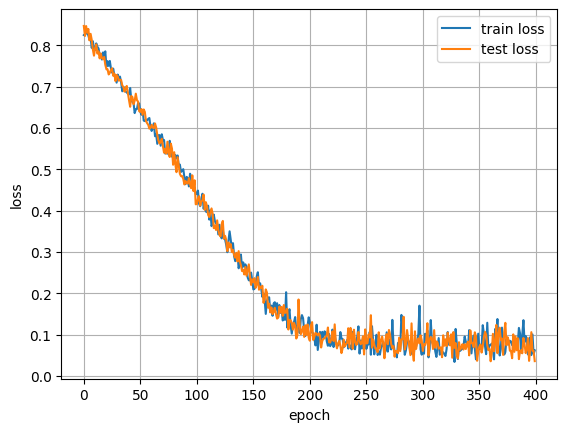

In [16]:
from matplotlib import pyplot as plt

plt.plot(train_history['loss'], label='train loss')
plt.plot(test_history['loss'], label='test loss')
plt.legend()

plt.grid()

plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
